In [2]:
# Datsset URL https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset

In [2]:
import tensorflow as tf
import numpy as np
import os
import random
from PIL import Image

In [3]:
# Count number of identities in the dataset
dataset_path = "cropped_face"
identities = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
NUM_IDENTITIES = len(identities)

print(f"Found {NUM_IDENTITIES} identities in dataset:")
for i, identity in enumerate(sorted(identities), 1):
    print(f"  {i}. {identity}")

Found 17 identities in dataset:
  1. Angelina Jolie
  2. Brad Pitt
  3. Denzel Washington
  4. Hugh Jackman
  5. Jennifer Lawrence
  6. Johnny Depp
  7. Kate Winslet
  8. Leonardo DiCaprio
  9. Megan Fox
  10. Natalie Portman
  11. Nicole Kidman
  12. Robert Downey Jr
  13. Sandra Bullock
  14. Scarlett Johansson
  15. Tom Cruise
  16. Tom Hanks
  17. Will Smith


In [ ]:
# Move random 20% of images from each identity for further EDGE device testing 
import shutil

source_folder = "cropped_face"
test_folder = "test_set"

# Check if test_set folder exists and has previously moved photos
if os.path.exists(test_folder):
    print("Test set folder exists. Checking for previously moved photos...")
    print("="*70)
    
    restored_count = 0
    for identity in os.listdir(test_folder):
        test_identity_path = os.path.join(test_folder, identity)
        
        if not os.path.isdir(test_identity_path):
            continue
        
        source_identity_path = os.path.join(source_folder, identity)
        os.makedirs(source_identity_path, exist_ok=True)
        
        # Get all images in test_set for this identity
        test_images = [f for f in os.listdir(test_identity_path) 
                      if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if len(test_images) > 0:
            # Restore images back to cropped_face
            for img_name in test_images:
                src_path = os.path.join(test_identity_path, img_name)
                dst_path = os.path.join(source_identity_path, img_name)
                shutil.move(src_path, dst_path)
                restored_count += 1
            
            print(f" {identity}: Restored {len(test_images)} images")
    
    if restored_count > 0:
        print(f"\n✓ Restored {restored_count} images back to '{source_folder}' folder")
    else:
        print(f"\n  No previously moved images found")
    print("="*70)
    print()

# Create test folder if it doesn't exist
os.makedirs(test_folder, exist_ok=True)

print(f"Moving 20% of images from each identity to '{test_folder}' folder")
print("="*70)

total_moved = 0
for identity in identities:
    source_identity_path = os.path.join(source_folder, identity)
    test_identity_path = os.path.join(test_folder, identity)
    
    # Create identity folder in test_set
    os.makedirs(test_identity_path, exist_ok=True)
    
    # Get all images for this identity
    all_images = [f for f in os.listdir(source_identity_path) 
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(all_images) == 0:
        print(f"   {identity}: No images found, skipping")
        continue
    
    # Calculate 20% of images (at least 1)
    num_to_move = max(1, int(len(all_images) * 0.20))
    
    # Randomly select images
    selected_images = random.sample(all_images, num_to_move)
    
    # Move images
    for img_name in selected_images:
        src_path = os.path.join(source_identity_path, img_name)
        dst_path = os.path.join(test_identity_path, img_name)
        shutil.move(src_path, dst_path)
    
    total_moved += num_to_move
    print(f"  {identity}: Moved {num_to_move} images ({num_to_move}/{len(all_images) + num_to_move} = {num_to_move/(len(all_images) + num_to_move)*100:.1f}%)")

print("="*70)
print(f"Test set created in '{test_folder}' folder")
print(f"  Total images moved: {total_moved}")


Test set folder exists. Checking for previously moved photos...
  ↩️  Angelina Jolie: Restored 19 images
  ↩️  Brad Pitt: Restored 17 images
  ↩️  Denzel Washington: Restored 18 images
  ↩️  Hugh Jackman: Restored 17 images
  ↩️  Jennifer Lawrence: Restored 19 images
  ↩️  Johnny Depp: Restored 19 images
  ↩️  Kate Winslet: Restored 19 images
  ↩️  Leonardo DiCaprio: Restored 19 images
  ↩️  Megan Fox: Restored 19 images
  ↩️  Natalie Portman: Restored 19 images
  ↩️  Nicole Kidman: Restored 19 images
  ↩️  Robert Downey Jr: Restored 18 images
  ↩️  Sandra Bullock: Restored 19 images
  ↩️  Scarlett Johansson: Restored 38 images
  ↩️  Tom Cruise: Restored 17 images
  ↩️  Tom Hanks: Restored 18 images
  ↩️  Will Smith: Restored 15 images

✓ Restored 329 images back to 'cropped_face' folder

Moving 20% of images from each identity to 'test_set' folder
  ✓ Angelina Jolie: Moved 19 images (19/115 = 16.5%)
  ✓ Brad Pitt: Moved 17 images (17/106 = 16.0%)
  ✓ Denzel Washington: Moved 18 images

VARIENT 1: CUSTOM CNN TRIPLET

In [5]:
# Custom L2 Normalization Layer (for proper serialization)
class L2Normalization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2Normalization, self).__init__(**kwargs)
    
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)
    
    def get_config(self):
        return super(L2Normalization, self).get_config()

print("L2Normalization layer defined")

def improved_face_embedding_model(embedding_dim=128):
    
    inputs = tf.keras.Input(shape=(96, 96, 1))

    # Block 1 
    x = tf.keras.layers.Conv2D(32, 3, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    # Block 2
    x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    # Block 3 
    x = tf.keras.layers.Conv2D(128, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)

    
    x = tf.keras.layers.Conv2D(192, 3, padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    
    x = tf.keras.layers.Dense(embedding_dim)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    outputs = L2Normalization()(x)  

    return tf.keras.Model(inputs, outputs)


print("  - BatchNormalization after each Conv2D")
print("  - filters:192 ")
print("  - 128D embeddings")
print("  - 4 Conv blocks")


L2Normalization layer defined
  - BatchNormalization after each Conv2D
  - filters:192 
  - 128D embeddings
  - 4 Conv blocks


In [6]:
# Triplet Data Generator
class ImprovedTripletDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset_path, image_size=(96, 96), batch_size=30, 
                 augment=True, triplets_per_batch=10):
        self.dataset_path = dataset_path
        self.image_size = image_size
        self.batch_size = batch_size
        self.augment = augment
        self.triplets_per_batch = triplets_per_batch
        
        # Load all image paths
        self.image_paths = []
        self.labels = []
        self.label_to_indices = {}
        
        identities = sorted([d for d in os.listdir(dataset_path) 
                           if os.path.isdir(os.path.join(dataset_path, d))])
        
        for label_idx, identity in enumerate(identities):
            identity_path = os.path.join(dataset_path, identity)
            images = [os.path.join(identity_path, f) 
                     for f in os.listdir(identity_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
            
            for img_path in images:
                self.image_paths.append(img_path)
                self.labels.append(label_idx)
            
            self.label_to_indices[label_idx] = [i for i, l in enumerate(self.labels) if l == label_idx]
        
        self.num_classes = len(identities)
        print(f"Loaded {len(self.image_paths)} images from {self.num_classes} identities")
        if augment:
            print("Data augmentation enabled")
    
    def __len__(self):
        return len(self.image_paths) // (self.batch_size // 3)
    
    def _augment_image(self, img_array):
        """Apply random augmentations"""
        # Random horizontal flip
        if random.random() > 0.5:
            img_array = np.fliplr(img_array)
        
        # Random rotation (-15 to +15 degrees)
        if random.random() > 0.5:
            angle = random.uniform(-15, 15)
            img_array = tf.keras.preprocessing.image.apply_affine_transform(
                img_array, theta=angle, fill_mode='nearest'
            )
        
        # Random brightness adjustment
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            img_array = np.clip(img_array * brightness_factor, 0, 1)
        
        return img_array
    
    def __getitem__(self, idx):
        # Generate triplets
        anchors = []
        positives = []
        negatives = []
        
        for _ in range(self.batch_size // 3):
            # Select random anchor class
            anchor_class = np.random.randint(0, self.num_classes)
            
            # Select anchor and positive from same class
            anchor_idx, positive_idx = np.random.choice(
                self.label_to_indices[anchor_class], size=2, replace=True
            )
            
            # Select negative from different class
            negative_class = np.random.choice(
                [c for c in range(self.num_classes) if c != anchor_class]
            )
            negative_idx = np.random.choice(self.label_to_indices[negative_class])
            
            # Load and preprocess images
            anchor_img = self._load_image(self.image_paths[anchor_idx])
            positive_img = self._load_image(self.image_paths[positive_idx])
            negative_img = self._load_image(self.image_paths[negative_idx])
            
            anchors.append(anchor_img)
            positives.append(positive_img)
            negatives.append(negative_img)
        
        # Stack and concatenate: [anchors, positives, negatives]
        anchors = np.array(anchors)
        positives = np.array(positives)
        negatives = np.array(negatives)
        
        triplet_images = np.concatenate([anchors, positives, negatives], axis=0)
        dummy_labels = np.zeros((len(triplet_images), 1))
        
        return triplet_images, dummy_labels
    
    def _load_image(self, path):
        img = tf.keras.preprocessing.image.load_img(
            path, color_mode='grayscale', target_size=self.image_size
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0  # Normalize
        
        # Apply augmentation
        if self.augment:
            img_array = self._augment_image(img_array)
        
        return img_array
    
    def on_epoch_end(self):
        pass

print(" data generator  defined")

 data generator  defined


TripletLoss class defined
  - Uses margin parameter for separation
  - Calculates anchor-positive and anchor-negative distances

Visualizing Sample Triplets (Anchor, Positive, Negative)


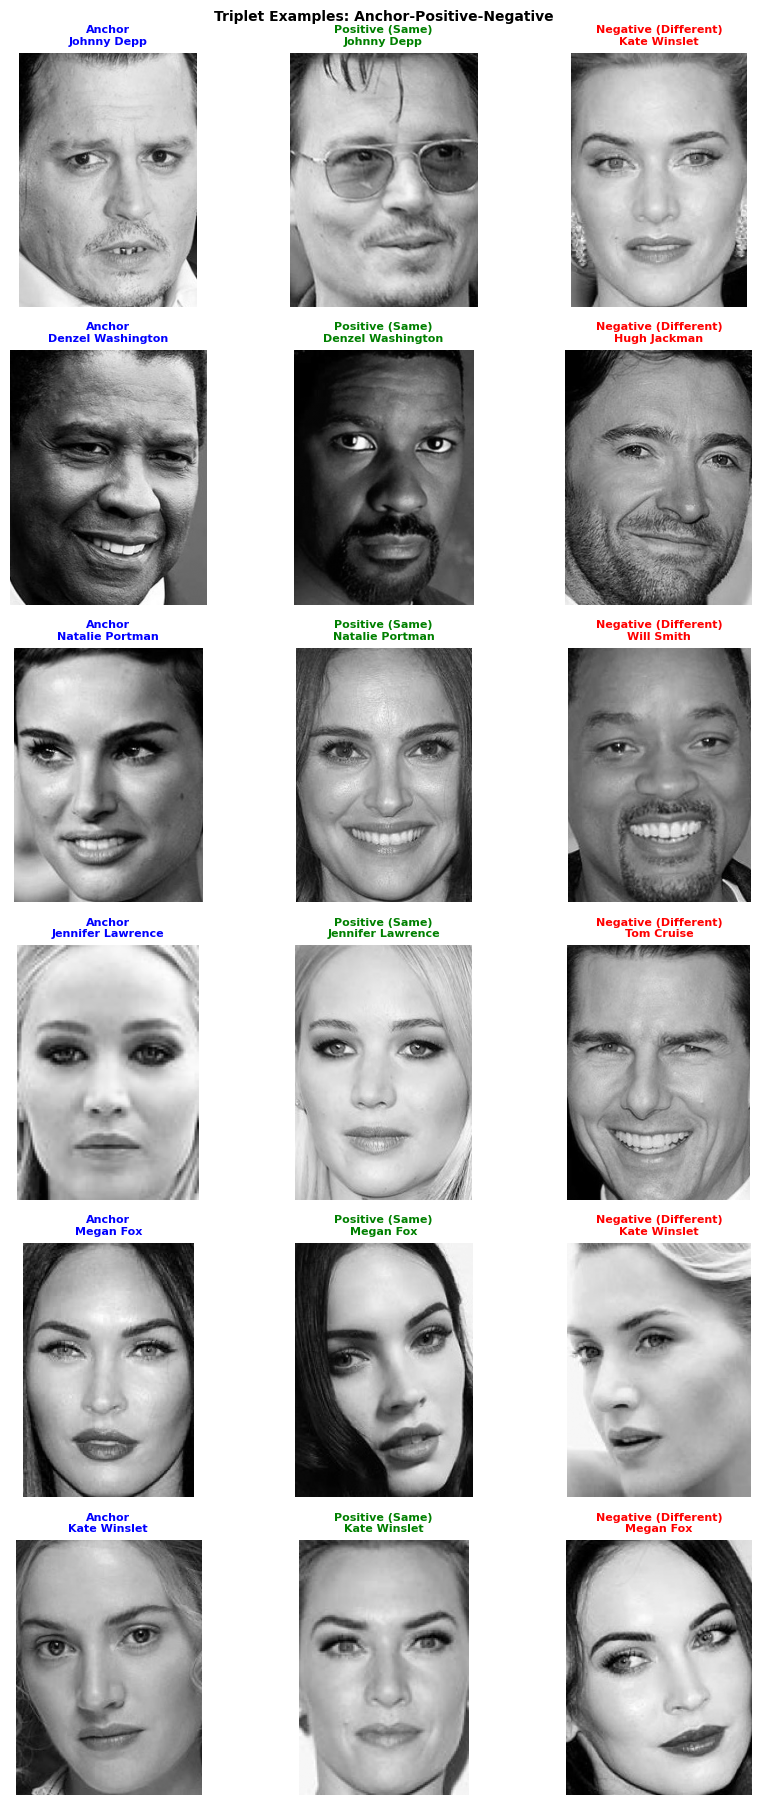

 Triplet visualization
  - Blue: Anchor image
  - Green: Positive (same identity as anchor)
  - Red: Negative (different identity)


In [7]:
# Triplet Loss Implementation
class TripletLoss(tf.keras.losses.Loss):
    def __init__(self, margin=0.5, **kwargs):
        super().__init__(**kwargs)
        self.margin = margin
    
    def call(self, y_true, y_pred):
        # Split embeddings into anchor, positive, negative
        batch_size = tf.shape(y_pred)[0] // 3
        
        anchor = y_pred[:batch_size]
        positive = y_pred[batch_size:2*batch_size]
        negative = y_pred[2*batch_size:]
        
        # Calculate distances
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
        
        # Triplet loss with margin
        loss = tf.maximum(pos_dist - neg_dist + self.margin, 0.0)
        
        return tf.reduce_mean(loss)

print("TripletLoss class defined")
print(f"  - Uses margin parameter for separation")
print(f"  - Calculates anchor-positive and anchor-negative distances")

# Visualize example triplets
print("\n" + "="*80)
print("Visualizing Sample Triplets (Anchor, Positive, Negative)")
print("="*80)

import matplotlib.pyplot as plt
from PIL import Image

# Number of triplet examples to visualize
num_triplets = 6
fig, axes = plt.subplots(num_triplets, 3, figsize=(9, num_triplets * 3))

# Organize identities and their images
identity_images = {}
for identity in identities:
    identity_path = os.path.join(dataset_path, identity)
    images = [os.path.join(identity_path, f) 
             for f in os.listdir(identity_path) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    if len(images) >= 2:  # Need at least 2 images for anchor and positive
        identity_images[identity] = images

for i in range(num_triplets):
    # Select random anchor identity
    anchor_identity = random.choice(list(identity_images.keys()))
    
    # Select anchor and positive from same identity
    anchor_img_path, positive_img_path = random.sample(identity_images[anchor_identity], 2)
    
    # Select negative from different identity
    negative_identity = random.choice([id for id in identity_images.keys() if id != anchor_identity])
    negative_img_path = random.choice(identity_images[negative_identity])
    
    # Load images
    anchor_img = Image.open(anchor_img_path).convert('L')
    positive_img = Image.open(positive_img_path).convert('L')
    negative_img = Image.open(negative_img_path).convert('L')
    
    # Display anchor
    axes[i, 0].imshow(anchor_img, cmap='gray')
    axes[i, 0].set_title(f'Anchor\n{anchor_identity}', fontsize=8, weight='bold', color='blue')
    axes[i, 0].axis('off')
    
    # Display positive
    axes[i, 1].imshow(positive_img, cmap='gray')
    axes[i, 1].set_title(f'Positive (Same)\n{anchor_identity}', fontsize=8 , weight='bold', color='green')
    axes[i, 1].axis('off')
    
    # Display negative
    axes[i, 2].imshow(negative_img, cmap='gray')
    axes[i, 2].set_title(f'Negative (Different)\n{negative_identity}', fontsize=8, weight='bold', color='red')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.suptitle('Triplet Examples: Anchor-Positive-Negative', fontsize=10, weight='bold', y=1.00)
plt.show()

print(" Triplet visualization")
print("  - Blue: Anchor image")
print("  - Green: Positive (same identity as anchor)")
print("  - Red: Negative (different identity)")
print("="*80)


In [8]:
# Create triplet model with INCREASED CAPACITY
print("Creating triplet model")

improved_triplet_model = improved_face_embedding_model(embedding_dim=128)

# Learning rate schedule with decay
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

# Compile with higher margin and learning rate schedule
improved_triplet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=TripletLoss(margin=0.8)  
)

print("Model compiled with:")
print(f"  - Initial LR: {initial_learning_rate}")
print(f"  - LR decay: 0.96 every 100 steps")
print(f"  - Margin: 0.8 ")
print(f"  - Embedding dimension: 128D")

print("\n" + "="*70)
improved_triplet_model.summary()



Creating triplet model

Model compiled with:
  - Initial LR: 0.001
  - LR decay: 0.96 every 100 steps
  - Margin: 0.8 
  - Embedding dimension: 128D



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 192)    │       221,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 192)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalization                │ (None, 128)            │             0 │
│ (L2Normalization)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 340,928 (1.30 MB)

 Trainable params: 339,840 (1.30 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [9]:
# Create data generator
improved_train_gen = ImprovedTripletDataGenerator(
    dataset_path="cropped_face",
    image_size=(96, 96),
    batch_size=30,
    augment=False,
    triplets_per_batch=10
)

print(f"\n Generator ready: {len(improved_train_gen)} batches per epoch")

Loaded 1346 images from 17 identities

 Generator ready: 134 batches per epoch


Training Improved Triplet Model
Configuration:
  - Epochs: 100 
  - Data augmentation: Enabled
  - BatchNormalization: Yes
  - Embedding dim: 128D
  - Margin: 0.8
  - Learning rate: 0.001 with decay
Epoch 1/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - loss: 0.5845
Epoch 1: loss improved from None to 0.53694, saving model to ./saved_model/facerecog_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 379ms/step - loss: 0.5369
Epoch 2/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - loss: 0.4376
Epoch 2: loss improved from 0.53694 to 0.45422, saving model to ./saved_model/facerecog_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 47s 347ms/step - loss: 0.4542
Epoch 3/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - loss: 0.4367
Epoch 3: loss improved from 0.45422 to 0.42537, saving model to ./saved_model/facerecog_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 49s 363ms/step - loss: 0.4254
Epoch 4/50
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 0.3660
Epoch 4: loss improved from 0.42537 to 0.36552, sav

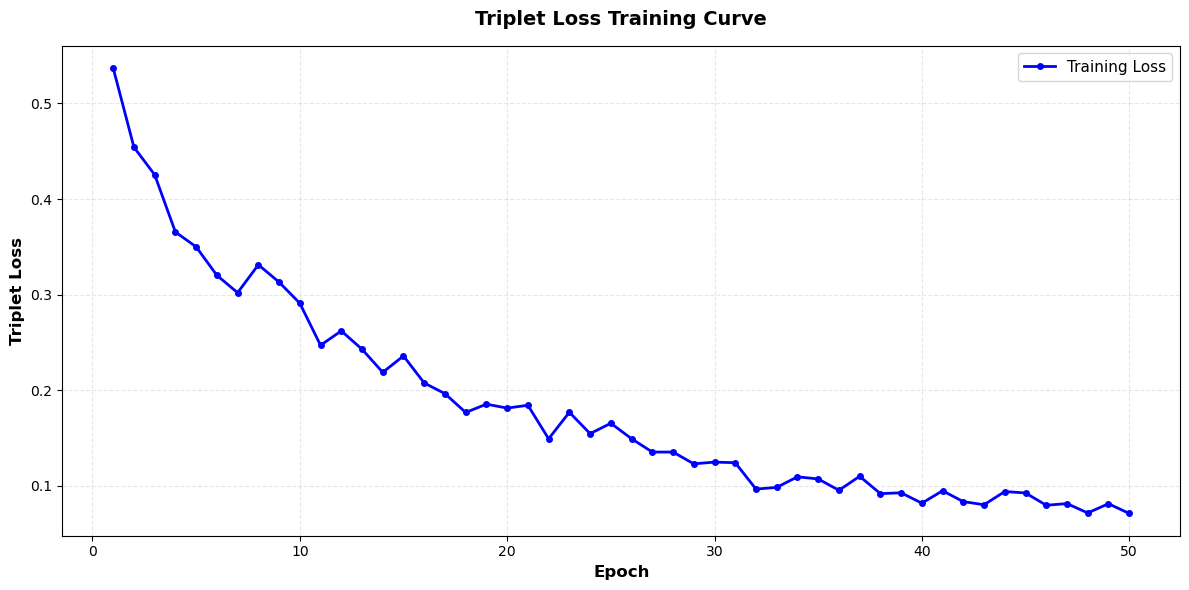


Training Statistics:
  Total epochs trained: 50
  Initial loss:         0.5369
  Final loss:           0.0712
  Best loss:            0.0712
  Loss reduction:       0.4658
  Improvement:          86.74%


In [ ]:
# Train model 
# Early stopping callback
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Model checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './saved_model/facerecog_model.keras',
    monitor='loss',
    save_best_only=True,
    verbose=1
)

# Train
improved_history = improved_triplet_model.fit(
    improved_train_gen,
    epochs=70,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

print("="*70)
print(" CNN face Recog triplet training complete")
print(f" Model saved: facerecog_model.keras")
print("="*70)

# Visualize training loss curve
import matplotlib.pyplot as plt

print("\nVisualizing Training Loss Curve")
print("="*70)

plt.figure(figsize=(12, 6))

# Plot training loss
epochs_trained = len(improved_history.history['loss'])
plt.plot(range(1, epochs_trained + 1), improved_history.history['loss'], 
         'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)

plt.title('Triplet Loss Training Curve', fontsize=14, weight='bold', pad=15)
plt.xlabel('Epoch', fontsize=12, weight='bold')
plt.ylabel('Triplet Loss', fontsize=12, weight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Print training statistics
print(f"\nTraining Statistics:")
print(f"  Total epochs trained: {epochs_trained}")
print(f"  Initial loss:         {improved_history.history['loss'][0]:.4f}")
print(f"  Final loss:           {improved_history.history['loss'][-1]:.4f}")
print(f"  Best loss:            {min(improved_history.history['loss']):.4f}")
print(f"  Loss reduction:       {(improved_history.history['loss'][0] - improved_history.history['loss'][-1]):.4f}")
print(f"  Improvement:          {((improved_history.history['loss'][0] - improved_history.history['loss'][-1]) / improved_history.history['loss'][0] * 100):.2f}%")
print("="*70)


In [26]:
# Save reference embeddings and identity names
print("Saving Reference Embeddings and Identity Names")
print("="*70)

# Create saved_model directory if it doesn't exist
import os
os.makedirs("./saved_model", exist_ok=True)

# Save reference embeddings and identity names
np.save("./saved_model/reference_embeddings.npy", improved_ref_array)
np.save("./saved_model/identity_names.npy", np.array(improved_identity_names))

print(f"✓ Saved reference embeddings")
print(f"  - reference_embeddings.npy: {len(improved_identity_names)} identities × {improved_ref_array.shape[1]}D")
print(f"  - identity_names.npy: {len(improved_identity_names)} names")
print(f"  Location: ./saved_model/")
print("="*70)

Saving Reference Embeddings and Identity Names
✓ Saved reference embeddings
  - reference_embeddings.npy: 17 identities × 128D
  - identity_names.npy: 17 names
  Location: ./saved_model/


VARIENT 2:FaceNet

In [10]:
# FaceNet-Inspired Architecture with Inception Modules
print("="*80)
print("VARIANT 2: FaceNet Architecture ")
print("="*80)

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3, 
                     filters_5x5_reduce, filters_5x5, filters_pool_proj):
    
    # 1x1 convolution branch
    conv_1x1 = tf.keras.layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(x)
    
    # 3x3 convolution branch
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_3x3 = tf.keras.layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)
    
    # 5x5 convolution branch
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(x)
    conv_5x5 = tf.keras.layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)
    
    # Max pooling branch
    pool = tf.keras.layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = tf.keras.layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool)
    
    # Concatenate all branches
    output = tf.keras.layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    
    return output


def facenet_model(embedding_dim=128):
    
    inputs = tf.keras.Input(shape=(96, 96, 1), name='input_image')
    
    # Initial convolution blocks
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', name='conv1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='bn1')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)
    
    x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', activation='relu', name='conv2_reduce')(x)
    x = tf.keras.layers.Conv2D(192, (3, 3), padding='same', activation='relu', name='conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn2')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool2')(x)
    
    # Inception Module 3a
    x = inception_module(x, 
                        filters_1x1=64,
                        filters_3x3_reduce=96, filters_3x3=128,
                        filters_5x5_reduce=16, filters_5x5=32,
                        filters_pool_proj=32)
    x = tf.keras.layers.BatchNormalization(name='bn_3a')(x)
    
    # Inception Module 3b
    x = inception_module(x,
                        filters_1x1=128,
                        filters_3x3_reduce=128, filters_3x3=192,
                        filters_5x5_reduce=32, filters_5x5=96,
                        filters_pool_proj=64)
    x = tf.keras.layers.BatchNormalization(name='bn_3b')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool3')(x)
    
    # Inception Module 4a
    x = inception_module(x,
                        filters_1x1=192,
                        filters_3x3_reduce=96, filters_3x3=208,
                        filters_5x5_reduce=16, filters_5x5=48,
                        filters_pool_proj=64)
    x = tf.keras.layers.BatchNormalization(name='bn_4a')(x)
    
    # Inception Module 4b
    x = inception_module(x,
                        filters_1x1=160,
                        filters_3x3_reduce=112, filters_3x3=224,
                        filters_5x5_reduce=24, filters_5x5=64,
                        filters_pool_proj=64)
    x = tf.keras.layers.BatchNormalization(name='bn_4b')(x)
    
    # Inception Module 4c
    x = inception_module(x,
                        filters_1x1=128,
                        filters_3x3_reduce=128, filters_3x3=256,
                        filters_5x5_reduce=24, filters_5x5=64,
                        filters_pool_proj=64)
    x = tf.keras.layers.BatchNormalization(name='bn_4c')(x)
    
    # Inception Module 4d
    x = inception_module(x,
                        filters_1x1=112,
                        filters_3x3_reduce=144, filters_3x3=288,
                        filters_5x5_reduce=32, filters_5x5=64,
                        filters_pool_proj=64)
    x = tf.keras.layers.BatchNormalization(name='bn_4d')(x)
    
    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    
    # Dropout for regularization
    x = tf.keras.layers.Dropout(0.4, name='dropout')(x)
    
    # Dense embedding layer
    x = tf.keras.layers.Dense(embedding_dim, name='dense_embedding')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_embedding')(x)
    
    # L2 normalization
    embeddings = L2Normalization(name='l2_normalization')(x)
    
    model = tf.keras.Model(inputs, embeddings, name='FaceNet')
    
    return model


# Create FaceNet model
print("\nCreating FaceNet model...")
facenet = facenet_model(embedding_dim=128)

print("FaceNet model created successfully")

facenet.summary()
print("="*80)

# Count total parameters
trainable_params = sum([tf.size(w).numpy() for w in facenet.trainable_weights])
print(f"\nTotal trainable parameters: {trainable_params:,}")
print("="*80)

VARIANT 2: FaceNet Architecture 

Creating FaceNet model...
FaceNet model created successfully


Model: "FaceNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 96, 96, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 48, 48,    │      3,200 │ input_image[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 48, 48,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 24, 24,    │          0 │ bn1[0][0]         │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_reduce        │ (None, 24, 24,    │      4,160 │ pool1[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 24, 24,    │    110,784 │ conv2_reduce[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 24, 24,    │        768 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 12, 12,    │          0 │ bn2[0][0]         │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 12, 12,    │     18,528 │ pool2[0][0]       │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 12,    │      3,088 │ pool2[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 12, 12,    │          0 │ pool2[0][0]       │
│ (MaxPooling2D)      │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 12, 12,    │     12,352 │ pool2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │    110,720 │ conv2d_5[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 12, 12,    │     12,832 │ conv2d_7[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 12, 12,    │      6,176 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 12,    │          0 │ conv2d_4[0][0],   │
│ (Concatenate)       │ 256)              │            │ conv2d_6[0][0],   │
│                     │                   │            │ conv2d_8[0][0],   │
│                     │                   │            │ conv2d_9[0][0]  

 Total params: 2,691,840 (10.27 MB)

 Trainable params: 2,685,472 (10.24 MB)

 Non-trainable params: 6,368 (24.88 KB)


Total trainable parameters: 2,685,472


In [11]:
# Compile FaceNet model
print("="*80)
print("Compiling FaceNet Model")
print("="*80)

# Learning rate schedule 
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=150,
    decay_rate=0.95,
    staircase=True
)

# Compile with triplet loss
facenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=TripletLoss(margin=0.5)  
)

print(" FaceNet compiled successfully")
print("\nTraining Configuration:")
print(f"  - Optimizer: Adam with exponential decay")
print(f"  - Initial learning rate: {initial_learning_rate}")
print(f"  - LR decay: 0.95 every 150 steps")
print(f"  - Loss: Triplet Loss with margin=0.5")
print(f"  - Embedding dimension: 128D")
print("="*80)

Compiling FaceNet Model
 FaceNet compiled successfully

Training Configuration:
  - Optimizer: Adam with exponential decay
  - Initial learning rate: 0.001
  - LR decay: 0.95 every 150 steps
  - Loss: Triplet Loss with margin=0.5
  - Embedding dimension: 128D


In [12]:
# Create FaceNet data generator 
print("="*80)
print("Creating FaceNet Training Data Generator")
print("="*80)

facenet_train_gen = ImprovedTripletDataGenerator(
    dataset_path="cropped_face",
    image_size=(96, 96),
    batch_size=30,  
    augment=False,  
    triplets_per_batch=10
)

print(f"Data generator created successfully")


Creating FaceNet Training Data Generator
Loaded 1346 images from 17 identities
Data generator created successfully


Training FaceNet Model

Training Configuration:
  - Model: FaceNet with Inception modules
  - Epochs: 70
  - Loss: Triplet Loss (margin=0.5)
  - Data augmentation: Disabled
  - Early stopping: Patience=20 epochs
  - Model checkpoint: Save best model only

Starting training...

Epoch 1/70


c:\Users\997ra\anaconda3\envs\KNCVU\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - loss: 0.4814
Epoch 1: loss improved from None to 0.48969, saving model to ./saved_model/facenet_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 72s 430ms/step - loss: 0.4897 - learning_rate: 0.0010
Epoch 2/70
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - loss: 0.4451
Epoch 2: loss improved from 0.48969 to 0.41621, saving model to ./saved_model/facenet_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 60s 449ms/step - loss: 0.4162 - learning_rate: 9.5000e-04
Epoch 3/70
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - loss: 0.3438
Epoch 3: loss improved from 0.41621 to 0.33904, saving model to ./saved_model/facenet_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 58s 430ms/step - loss: 0.3390 - learning_rate: 9.0250e-04
Epoch 4/70
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 0.3374
Epoch 4: loss improved from 0.33904 to 0.31481, saving model to ./saved_model/facenet_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 63s 471ms/step - loss: 0.3148 - learning_rate: 8.5737e-04
Ep

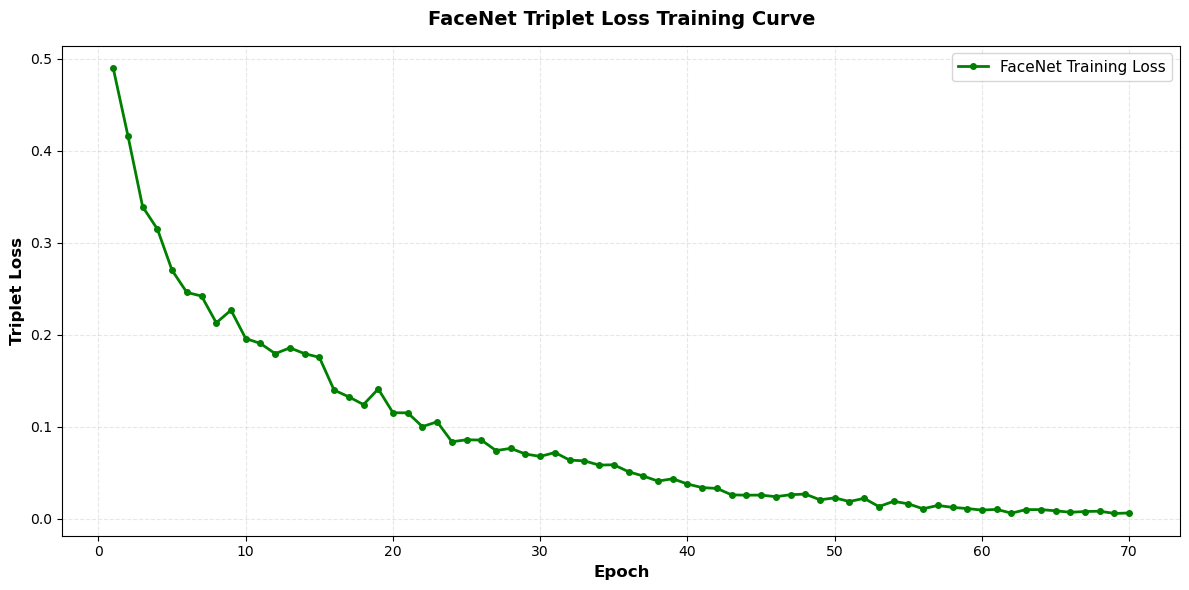


 Training Statistics:
  Total epochs trained: 70
  Initial loss:         0.4897
  Final loss:           0.0063
  Best loss:            0.0058
  Loss reduction:       0.4834
  Improvement:          98.71%


In [16]:
# Train FaceNet model
print("="*80)
print("Training FaceNet Model")
print("="*80)
print("\nTraining Configuration:")
print("  - Model: FaceNet with Inception modules")
print("  - Epochs: 70")
print("  - Loss: Triplet Loss (margin=0.5)")
print("  - Data augmentation: Disabled")
print("  - Early stopping: Patience=20 epochs")
print("  - Model checkpoint: Save best model only")
print("="*80)
print("\nStarting training...\n")

# Callbacks
facenet_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

facenet_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './saved_model/facenet_model.keras',
    monitor='loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train the model
facenet_history = facenet.fit(
    facenet_train_gen,
    epochs=70,
    callbacks=[facenet_early_stop, facenet_checkpoint, reduce_lr],
    verbose=1
)

print("\n" + "="*80)
print("✓ FaceNet Training Complete")
print(f"✓ Model saved: ./saved_model/facenet_model.keras")
print("="*80)

# Visualize training loss
import matplotlib.pyplot as plt

print("\nVisualizing FaceNet Training Loss Curve")
print("="*80)

plt.figure(figsize=(12, 6))

epochs_trained = len(facenet_history.history['loss'])
plt.plot(range(1, epochs_trained + 1), facenet_history.history['loss'], 
         'g-', linewidth=2, label='FaceNet Training Loss', marker='o', markersize=4)

plt.title('FaceNet Triplet Loss Training Curve', fontsize=14, weight='bold', pad=15)
plt.xlabel('Epoch', fontsize=12, weight='bold')
plt.ylabel('Triplet Loss', fontsize=12, weight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Print training statistics
print(f"\n Training Statistics:")
print(f"  Total epochs trained: {epochs_trained}")
print(f"  Initial loss:         {facenet_history.history['loss'][0]:.4f}")
print(f"  Final loss:           {facenet_history.history['loss'][-1]:.4f}")
print(f"  Best loss:            {min(facenet_history.history['loss']):.4f}")
print(f"  Loss reduction:       {(facenet_history.history['loss'][0] - facenet_history.history['loss'][-1]):.4f}")
print(f"  Improvement:          {((facenet_history.history['loss'][0] - facenet_history.history['loss'][-1]) / facenet_history.history['loss'][0] * 100):.2f}%")
print("="*80)

In [ ]:
# Generate and save FaceNet reference embeddings
print("="*80)
print("Generating FaceNet Reference Embeddings")
print("="*80)

facenet_ref_embeddings = []
facenet_identity_names = []

for identity in sorted(identities):
    identity_path = os.path.join(dataset_path, identity)
    images = [os.path.join(identity_path, f) 
             for f in os.listdir(identity_path) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(images) == 0:
        continue
    
    # Load and preprocess all images for this identity
    identity_embeddings = []
    for img_path in images:
        img = tf.keras.preprocessing.image.load_img(
            img_path, color_mode='grayscale', target_size=(96, 96)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Generate embedding
        embedding = facenet.predict(img_array, verbose=0)
        identity_embeddings.append(embedding[0])
    
    # Average embeddings for this identity
    avg_embedding = np.mean(identity_embeddings, axis=0)
    facenet_ref_embeddings.append(avg_embedding)
    facenet_identity_names.append(identity)
    
    print(f"   {identity}: {len(images)} images → averaged embedding")

# Convert to numpy array
facenet_ref_array = np.array(facenet_ref_embeddings)

print("="*80)
print(f"✓ Generated reference embeddings for {len(facenet_identity_names)} identities")
print(f"  Shape: {facenet_ref_array.shape}")
print("="*80)

# Save reference embeddings and identity names
print("\nSaving FaceNet Reference Embeddings and Identity Names")
print("="*80)

np.save("./saved_model/facenet_reference_embeddings.npy", facenet_ref_array)
np.save("./saved_model/facenet_identity_names.npy", np.array(facenet_identity_names))

print(f"Saved FaceNet reference embeddings")
print(f"  - facenet_reference_embeddings.npy: {len(facenet_identity_names)} identities × {facenet_ref_array.shape[1]}D")
print(f"  - facenet_identity_names.npy: {len(facenet_identity_names)} names")
print(f"  Location: ./saved_model/")
print("="*80)

Generating FaceNet Reference Embeddings
  ✓ Angelina Jolie: 77 images → averaged embedding
  ✓ Brad Pitt: 72 images → averaged embedding
  ✓ Denzel Washington: 73 images → averaged embedding
  ✓ Hugh Jackman: 69 images → averaged embedding
  ✓ Jennifer Lawrence: 80 images → averaged embedding
  ✓ Johnny Depp: 77 images → averaged embedding
  ✓ Kate Winslet: 78 images → averaged embedding
  ✓ Leonardo DiCaprio: 79 images → averaged embedding
  ✓ Megan Fox: 77 images → averaged embedding
  ✓ Natalie Portman: 76 images → averaged embedding
  ✓ Nicole Kidman: 79 images → averaged embedding
  ✓ Robert Downey Jr: 73 images → averaged embedding
  ✓ Sandra Bullock: 77 images → averaged embedding
  ✓ Scarlett Johansson: 154 images → averaged embedding
  ✓ Tom Cruise: 70 images → averaged embedding
  ✓ Tom Hanks: 74 images → averaged embedding
  ✓ Will Smith: 61 images → averaged embedding
✓ Generated reference embeddings for 17 identities
  Shape: (17, 128)

Saving FaceNet Reference Embeddings 

Varient: 3

In [13]:
# OpenFace NN4 Architecture (Lightweight CNN)
print("="*80)
print("VARIANT 3: OpenFace NN4 ")
print("="*80)

def openface_nn4_model(embedding_dim=128):
    
    inputs = tf.keras.Input(shape=(96, 96, 1), name='input_image')
    
    # Block 1: Initial feature extraction
    x = tf.keras.layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1_1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='bn1_1')(x)
    x = tf.keras.layers.Activation('relu', name='relu1_1')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)
    
    # Block 2: Feature refinement
    x = tf.keras.layers.Conv2D(64, (1, 1), padding='same', name='conv2_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn2_1')(x)
    x = tf.keras.layers.Activation('relu', name='relu2_1')(x)
    
    x = tf.keras.layers.Conv2D(192, (3, 3), padding='same', name='conv2_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn2_2')(x)
    x = tf.keras.layers.Activation('relu', name='relu2_2')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool2')(x)
    
    # Block 3: Deep feature extraction (NN4 style)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='conv3_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn3_1')(x)
    x = tf.keras.layers.Activation('relu', name='relu3_1')(x)
    
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', name='conv3_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn3_2')(x)
    x = tf.keras.layers.Activation('relu', name='relu3_2')(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv3_3')(x)
    x = tf.keras.layers.BatchNormalization(name='bn3_3')(x)
    x = tf.keras.layers.Activation('relu', name='relu3_3')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='pool3')(x)
    
    # Block 4: Compact representation
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv4_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn4_1')(x)
    x = tf.keras.layers.Activation('relu', name='relu4_1')(x)
    
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv4_2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn4_2')(x)
    x = tf.keras.layers.Activation('relu', name='relu4_2')(x)
    
    # Block 5: Final feature maps
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', name='conv5_1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn5_1')(x)
    x = tf.keras.layers.Activation('relu', name='relu5_1')(x)
    
    # Global Average Pooling
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    
    # Fully connected layers for embeddings
    x = tf.keras.layers.Dense(256, name='fc1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_fc1')(x)
    x = tf.keras.layers.Activation('relu', name='relu_fc1')(x)
    x = tf.keras.layers.Dropout(0.3, name='dropout1')(x)
    
    x = tf.keras.layers.Dense(embedding_dim, name='fc2_embedding')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_fc2')(x)
    
    # L2 normalization for unit embeddings
    embeddings = L2Normalization(name='l2_normalization')(x)
    
    model = tf.keras.Model(inputs, embeddings, name='OpenFace_NN4')
    
    return model


# Create OpenFace NN4 model
print("\nCreating OpenFace NN4 model...")
openface = openface_nn4_model(embedding_dim=128)

print(" OpenFace NN4 model created successfully")

openface.summary()
print("="*80)

# Count total parameters
trainable_params = sum([tf.size(w).numpy() for w in openface.trainable_weights])
print(f"\nTotal trainable parameters: {trainable_params:,}")


VARIANT 3: OpenFace NN4 

Creating OpenFace NN4 model...
 OpenFace NN4 model created successfully


Model: "OpenFace_NN4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 48, 48, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1_1 (BatchNormalization)      │ (None, 48, 48, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu1_1 (Activation)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 24, 24, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_1 (BatchNormalization)      │ (None, 24, 24, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_1 (Activation)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2 (Conv2D)                │ (None, 24, 24, 192)    │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2_2 (BatchNormalization)      │ (None, 24, 24, 192)    │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu2_2 (Activation)            │ (None, 24, 24, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 12, 12, 128)    │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_1 (BatchNormalization)      │ (None, 12, 12, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_1 (Activation)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2 (Conv2D)                │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_2 (BatchNormalization)      │ (None, 12, 12, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_2 (Activation)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3 (Conv2D)                │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn3_3 (BatchNormalization)      │ (None, 12, 12, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu3_3 (Activation)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn4_1 (BatchNormalization)      │ (None, 6, 6, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ relu4_1 (Activation)            │ (None, 6, 6, 256)      │             

 Total params: 2,659,072 (10.14 MB)

 Trainable params: 2,655,104 (10.13 MB)

 Non-trainable params: 3,968 (15.50 KB)


Total trainable parameters: 2,655,104


In [14]:
# Compile OpenFace NN4 model
print("="*80)
print("Compiling OpenFace NN4 Model")
print("="*80)

# Learning rate schedule - more aggressive for lightweight model
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

# Compile with triplet loss
openface.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=TripletLoss(margin=0.6)  # Slightly higher margin for lightweight model
)

print("OpenFace NN4 compiled successfully")


Compiling OpenFace NN4 Model
OpenFace NN4 compiled successfully


In [15]:
# Create OpenFace NN4 data generator
print("="*80)
print("Creating OpenFace NN4 Training Data Generator")
print("="*80)

openface_train_gen = ImprovedTripletDataGenerator(
    dataset_path="cropped_face",
    image_size=(96, 96),
    batch_size=30,  
    augment=False,  
    triplets_per_batch=10
)

print(f"Data generator created successfully")


Creating OpenFace NN4 Training Data Generator
Loaded 1346 images from 17 identities
Data generator created successfully


Training OpenFace NN4 Model

Training Configuration:
  - Model: OpenFace NN4 (Lightweight CNN)
  - Epochs: 70
  - Loss: Triplet Loss (margin=0.6)
  - Data augmentation: Disabled
  - Early stopping: Patience=20 epochs
  - Model checkpoint: Save best model only

Starting training...

Epoch 1/70
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 0.5205
Epoch 1: loss improved from None to 0.46617, saving model to ./saved_model/openface_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 61s 406ms/step - loss: 0.4662 - learning_rate: 9.6000e-04
Epoch 2/70
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 0.4402
Epoch 2: loss improved from 0.46617 to 0.43810, saving model to ./saved_model/openface_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 395ms/step - loss: 0.4381 - learning_rate: 9.2160e-04
Epoch 3/70
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - loss: 0.4178
Epoch 3: loss improved from 0.43810 to 0.39244, saving model to ./saved_model/openface_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 53s 392ms/ste

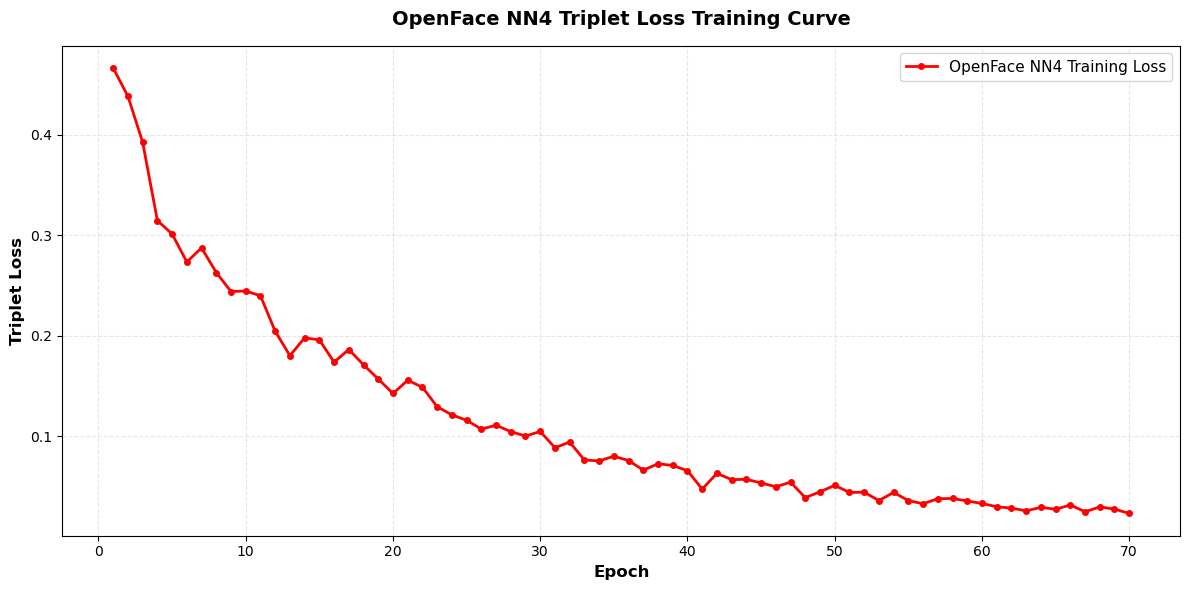


✓ Training Statistics:
  Total epochs trained: 70
  Initial loss:         0.4662
  Final loss:           0.0229
  Best loss:            0.0229
  Loss reduction:       0.4432
  Improvement:          95.08%


In [ ]:
# Train OpenFace NN4 model


# Callbacks
openface_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

openface_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './saved_model/openface_model.keras',
    monitor='loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train the model
openface_history = openface.fit(
    openface_train_gen,
    epochs=70,
    callbacks=[openface_early_stop, openface_checkpoint, reduce_lr],
    verbose=1
)

print("\n" + "="*80)
print("OpenFace NN4 Training Complete")
print(f" Model saved: ./saved_model/openface_model.keras")
print("="*80)

# Visualize training loss
import matplotlib.pyplot as plt

print("\nVisualizing OpenFace NN4 Training Loss Curve")
print("="*80)

plt.figure(figsize=(12, 6))

epochs_trained = len(openface_history.history['loss'])
plt.plot(range(1, epochs_trained + 1), openface_history.history['loss'], 
         'r-', linewidth=2, label='OpenFace NN4 Training Loss', marker='o', markersize=4)

plt.title('OpenFace NN4 Triplet Loss Training Curve', fontsize=14, weight='bold', pad=15)
plt.xlabel('Epoch', fontsize=12, weight='bold')
plt.ylabel('Triplet Loss', fontsize=12, weight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Print training statistics
print(f"\n✓ Training Statistics:")
print(f"  Total epochs trained: {epochs_trained}")
print(f"  Initial loss:         {openface_history.history['loss'][0]:.4f}")
print(f"  Final loss:           {openface_history.history['loss'][-1]:.4f}")
print(f"  Best loss:            {min(openface_history.history['loss']):.4f}")
print(f"  Loss reduction:       {(openface_history.history['loss'][0] - openface_history.history['loss'][-1]):.4f}")
print(f"  Improvement:          {((openface_history.history['loss'][0] - openface_history.history['loss'][-1]) / openface_history.history['loss'][0] * 100):.2f}%")
print("="*80)

In [22]:
# Generate and save OpenFace NN4 reference embeddings
print("="*80)
print("Generating OpenFace NN4 Reference Embeddings")
print("="*80)

openface_ref_embeddings = []
openface_identity_names = []

for identity in sorted(identities):
    identity_path = os.path.join(dataset_path, identity)
    images = [os.path.join(identity_path, f) 
             for f in os.listdir(identity_path) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(images) == 0:
        continue
    
    # Load and preprocess all images for this identity
    identity_embeddings = []
    for img_path in images:
        img = tf.keras.preprocessing.image.load_img(
            img_path, color_mode='grayscale', target_size=(96, 96)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Generate embedding
        embedding = openface.predict(img_array, verbose=0)
        identity_embeddings.append(embedding[0])
    
    # Average embeddings for this identity
    avg_embedding = np.mean(identity_embeddings, axis=0)
    openface_ref_embeddings.append(avg_embedding)
    openface_identity_names.append(identity)
    
    print(f"  ✓ {identity}: {len(images)} images → averaged embedding")

# Convert to numpy array
openface_ref_array = np.array(openface_ref_embeddings)

print("="*80)
print(f"✓ Generated reference embeddings for {len(openface_identity_names)} identities")
print(f"  Shape: {openface_ref_array.shape}")
print("="*80)

# Save reference embeddings and identity names
print("\nSaving OpenFace NN4 Reference Embeddings and Identity Names")
print("="*80)

np.save("./saved_model/openface_reference_embeddings.npy", openface_ref_array)
np.save("./saved_model/openface_identity_names.npy", np.array(openface_identity_names))

print(f"✓ Saved OpenFace NN4 reference embeddings")
print(f"  - openface_reference_embeddings.npy: {len(openface_identity_names)} identities × {openface_ref_array.shape[1]}D")
print(f"  - openface_identity_names.npy: {len(openface_identity_names)} names")
print(f"  Location: ./saved_model/")
print("="*80)

Generating OpenFace NN4 Reference Embeddings
  ✓ Angelina Jolie: 77 images → averaged embedding
  ✓ Brad Pitt: 72 images → averaged embedding
  ✓ Denzel Washington: 73 images → averaged embedding
  ✓ Hugh Jackman: 69 images → averaged embedding
  ✓ Jennifer Lawrence: 80 images → averaged embedding
  ✓ Johnny Depp: 77 images → averaged embedding
  ✓ Kate Winslet: 78 images → averaged embedding
  ✓ Leonardo DiCaprio: 79 images → averaged embedding
  ✓ Megan Fox: 77 images → averaged embedding
  ✓ Natalie Portman: 76 images → averaged embedding
  ✓ Nicole Kidman: 79 images → averaged embedding
  ✓ Robert Downey Jr: 73 images → averaged embedding
  ✓ Sandra Bullock: 77 images → averaged embedding
  ✓ Scarlett Johansson: 154 images → averaged embedding
  ✓ Tom Cruise: 70 images → averaged embedding
  ✓ Tom Hanks: 74 images → averaged embedding
  ✓ Will Smith: 61 images → averaged embedding
✓ Generated reference embeddings for 17 identities
  Shape: (17, 128)

Saving OpenFace NN4 Reference E

Varient 4: 

In [16]:
# VGGFace Architecture (VGG-16 Backbone)
print("="*80)
print("VARIANT 4: VGGFace")
print("="*80)

def vggface_model(embedding_dim=128):
    """
  
    """
    inputs = tf.keras.Input(shape=(96, 96, 1), name='input_image')
    
    # Block 1: 64 filters
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1')(inputs)
    x = tf.keras.layers.BatchNormalization(name='block1_bn1')(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block1_bn2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    # Block 2: 128 filters
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block2_bn1')(x)
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block2_bn2')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    # Block 3: 256 filters (3 conv layers)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block3_bn1')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block3_bn2')(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv3')(x)
    x = tf.keras.layers.BatchNormalization(name='block3_bn3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    
    # Block 4: 512 filters (3 conv layers)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block4_bn1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block4_bn2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv3')(x)
    x = tf.keras.layers.BatchNormalization(name='block4_bn3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    
    # Block 5: 512 filters (3 conv layers)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv1')(x)
    x = tf.keras.layers.BatchNormalization(name='block5_bn1')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv2')(x)
    x = tf.keras.layers.BatchNormalization(name='block5_bn2')(x)
    x = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block5_conv3')(x)
    x = tf.keras.layers.BatchNormalization(name='block5_bn3')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    
    # Global Average Pooling instead of Flatten (more efficient)
    x = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    
    # Fully connected layers for face embeddings
    x = tf.keras.layers.Dense(512, name='fc1')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_fc1')(x)
    x = tf.keras.layers.Activation('relu', name='relu_fc1')(x)
    x = tf.keras.layers.Dropout(0.4, name='dropout1')(x)
    
    x = tf.keras.layers.Dense(256, name='fc2')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_fc2')(x)
    x = tf.keras.layers.Activation('relu', name='relu_fc2')(x)
    x = tf.keras.layers.Dropout(0.4, name='dropout2')(x)
    
    # Final embedding layer (softmax removed)
    x = tf.keras.layers.Dense(embedding_dim, name='fc_embedding')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_embedding')(x)
    
    # L2 normalization for unit embeddings
    embeddings = L2Normalization(name='l2_normalization')(x)
    
    model = tf.keras.Model(inputs, embeddings, name='VGGFace')
    
    return model


# Create VGGFace model
print("\nCreating VGGFace model...")
vggface = vggface_model(embedding_dim=128)

print("VGGFace model created successfully")
vggface.summary()
print("="*80)

# Count total parameters
trainable_params = sum([tf.size(w).numpy() for w in vggface.trainable_weights])
print(f"\n Total trainable parameters: {trainable_params:,}")


VARIANT 4: VGGFace

Creating VGGFace model...
VGGFace model created successfully


Model: "VGGFace"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn1 (BatchNormalization) │ (None, 96, 96, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_bn2 (BatchNormalization) │ (None, 96, 96, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn1 (BatchNormalization) │ (None, 48, 48, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_bn2 (BatchNormalization) │ (None, 48, 48, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn1 (BatchNormalization) │ (None, 24, 24, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn2 (BatchNormalization) │ (None, 24, 24, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_bn3 (BatchNormalization) │ (None, 24, 24, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_bn1 (BatchNormalization) │ (None, 12, 12, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_bn2 (BatchNormalization) │ (None, 12, 12, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_bn3 (BatchNormalization) │ (None, 12, 12, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             

 Total params: 15,160,896 (57.83 MB)

 Trainable params: 15,150,656 (57.80 MB)

 Non-trainable params: 10,240 (40.00 KB)


 Total trainable parameters: 15,150,656


In [17]:
# Compile VGGFace model
print("="*80)
print("Compiling VGGFace Model")
print("="*80)

# Learning rate schedule - slower for deep network
initial_learning_rate = 0.0005  # Lower LR for deep VGG architecture
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=150,
    decay_rate=0.94,
    staircase=True
)

# Compile with triplet loss
vggface.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=TripletLoss(margin=0.5)  # Standard margin for VGGFace
)

print(" VGGFace compiled successfully")


Compiling VGGFace Model
 VGGFace compiled successfully


In [18]:
# Create VGGFace data generator
print("="*80)
print("Creating VGGFace Training Data Generator")
print("="*80)

vggface_train_gen = ImprovedTripletDataGenerator(
    dataset_path="cropped_face",
    image_size=(96, 96),
    batch_size=30,  
    augment=False,  
    triplets_per_batch=10
)

print(f" Data generator created successfully")

Creating VGGFace Training Data Generator
Loaded 1346 images from 17 identities
 Data generator created successfully


Training VGGFace Model

Training Configuration:
  - Model: VGGFace (VGG-16 backbone)
  - Epochs: 70
  - Loss: Triplet Loss (margin=0.5)
  - Data augmentation: Disabled
  - Early stopping: Patience=20 epochs
  - Model checkpoint: Save best model only

Starting training...

Epoch 1/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 0.1971
Epoch 1: loss improved from None to 0.19906, saving model to ./saved_model/vggface_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 498s 4s/step - loss: 0.1991 - learning_rate: 2.5315e-04
Epoch 2/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.2453
Epoch 2: loss did not improve from 0.19906
134/134 ━━━━━━━━━━━━━━━━━━━━ 460s 3s/step - loss: 0.2310 - learning_rate: 2.5315e-04
Epoch 3/25
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.1811
Epoch 3: loss improved from 0.19906 to 0.17444, saving model to ./saved_model/vggface_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 491s 3s/step - loss: 0.1744 - learning_rate: 2.3796e-04
Epoch 4/25
134/134 ━━━━━━━━━━━━━━━━━━━

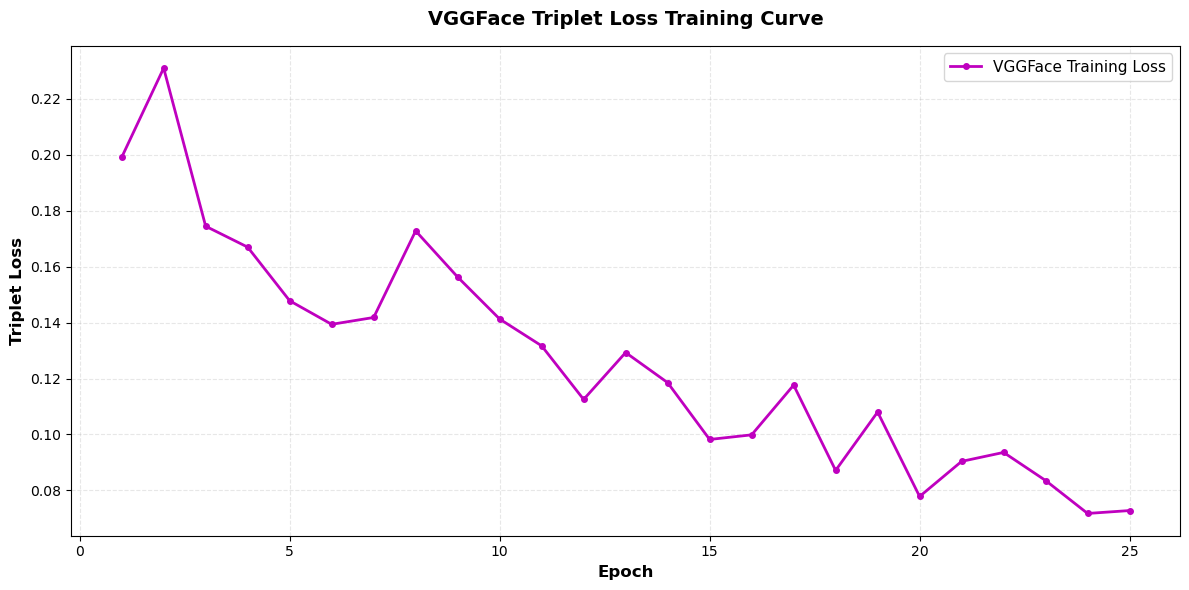


✓ Training Statistics:
  Total epochs trained: 25
  Initial loss:         0.1991
  Final loss:           0.0728
  Best loss:            0.0718
  Loss reduction:       0.1263
  Improvement:          63.42%


In [ ]:
# Train VGGFace model
print("="*80)
print("Training VGGFace Model")
print("="*80)
print("\nTraining Configuration:")
print("  - Model: VGGFace (VGG-16 backbone)")
print("  - Epochs: 70")
print("  - Loss: Triplet Loss (margin=0.5)")
print("  - Data augmentation: Disabled")
print("  - Early stopping: Patience=20 epochs")
print("  - Model checkpoint: Save best model only")
print("="*80)
print("\nStarting training...\n")

# Callbacks
vggface_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

vggface_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    './saved_model/vggface_model.keras',
    monitor='loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Reduce learning rate on plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train the model
vggface_history = vggface.fit(
    vggface_train_gen,
    epochs=25,
    callbacks=[vggface_early_stop, vggface_checkpoint, reduce_lr],
    verbose=1
)

print("\n" + "="*80)
print(" VGGFace Training Complete")
print(f" Model saved: ./saved_model/vggface_model.keras")
print("="*80)

# Visualize training loss
import matplotlib.pyplot as plt

print("\nVisualizing VGGFace Training Loss Curve")
print("="*80)

plt.figure(figsize=(12, 6))

epochs_trained = len(vggface_history.history['loss'])
plt.plot(range(1, epochs_trained + 1), vggface_history.history['loss'], 
         'm-', linewidth=2, label='VGGFace Training Loss', marker='o', markersize=4)

plt.title('VGGFace Triplet Loss Training Curve', fontsize=14, weight='bold', pad=15)
plt.xlabel('Epoch', fontsize=12, weight='bold')
plt.ylabel('Triplet Loss', fontsize=12, weight='bold')
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Print training statistics
print(f"\n✓ Training Statistics:")
print(f"  Total epochs trained: {epochs_trained}")
print(f"  Initial loss:         {vggface_history.history['loss'][0]:.4f}")
print(f"  Final loss:           {vggface_history.history['loss'][-1]:.4f}")
print(f"  Best loss:            {min(vggface_history.history['loss']):.4f}")
print(f"  Loss reduction:       {(vggface_history.history['loss'][0] - vggface_history.history['loss'][-1]):.4f}")
print(f"  Improvement:          {((vggface_history.history['loss'][0] - vggface_history.history['loss'][-1]) / vggface_history.history['loss'][0] * 100):.2f}%")
print("="*80)

In [ ]:
# Generate and save VGGFace reference embeddings
print("="*80)
print("Generating VGGFace Reference Embeddings")
print("="*80)

vggface_ref_embeddings = []
vggface_identity_names = []

for identity in sorted(identities):
    identity_path = os.path.join(dataset_path, identity)
    images = [os.path.join(identity_path, f) 
             for f in os.listdir(identity_path) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if len(images) == 0:
        continue
    
    # Load and preprocess all images for this identity
    identity_embeddings = []
    for img_path in images:
        img = tf.keras.preprocessing.image.load_img(
            img_path, color_mode='grayscale', target_size=(96, 96)
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = img_array / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Generate embedding
        embedding = vggface.predict(img_array, verbose=0)
        identity_embeddings.append(embedding[0])
    
    # Average embeddings for this identity
    avg_embedding = np.mean(identity_embeddings, axis=0)
    vggface_ref_embeddings.append(avg_embedding)
    vggface_identity_names.append(identity)
    
    print(f"  ✓ {identity}: {len(images)} images → averaged embedding")

# Convert to numpy array
vggface_ref_array = np.array(vggface_ref_embeddings)

print("="*80)
print(f" Generated reference embeddings for {len(vggface_identity_names)} identities")
print(f"  Shape: {vggface_ref_array.shape}")
print("="*80)

# Save reference embeddings and identity names
print("\nSaving VGGFace Reference Embeddings and Identity Names")
print("="*80)

np.save("./saved_model/vggface_reference_embeddings.npy", vggface_ref_array)
np.save("./saved_model/vggface_identity_names.npy", np.array(vggface_identity_names))

print(f"Saved VGGFace reference embeddings")
print(f"  - vggface_reference_embeddings.npy: {len(vggface_identity_names)} identities × {vggface_ref_array.shape[1]}D")
print(f"  - vggface_identity_names.npy: {len(vggface_identity_names)} names")
print(f"  Location: ./saved_model/")
print("="*80)

Generating VGGFace Reference Embeddings
  ✓ Angelina Jolie: 77 images → averaged embedding
  ✓ Brad Pitt: 72 images → averaged embedding
  ✓ Denzel Washington: 73 images → averaged embedding
  ✓ Hugh Jackman: 69 images → averaged embedding
  ✓ Jennifer Lawrence: 80 images → averaged embedding
  ✓ Johnny Depp: 77 images → averaged embedding
  ✓ Kate Winslet: 78 images → averaged embedding
  ✓ Leonardo DiCaprio: 79 images → averaged embedding
  ✓ Megan Fox: 77 images → averaged embedding
  ✓ Natalie Portman: 76 images → averaged embedding
  ✓ Nicole Kidman: 79 images → averaged embedding
  ✓ Robert Downey Jr: 73 images → averaged embedding
  ✓ Sandra Bullock: 77 images → averaged embedding
  ✓ Scarlett Johansson: 154 images → averaged embedding
  ✓ Tom Cruise: 70 images → averaged embedding
  ✓ Tom Hanks: 74 images → averaged embedding
  ✓ Will Smith: 61 images → averaged embedding
✓ Generated reference embeddings for 17 identities
  Shape: (17, 128)

Saving VGGFace Reference Embeddings 

TestingModel

In [21]:
# Comprehensive Model Evaluation - All 4 Variants
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

print("="*100)
print(" "*30 + "MODEL EVALUATION - ALL VARIANTS")
print("="*100)

# Define model configurations
model_configs = [
    {
        'name': 'Variant 1: Custom CNN',
        'short_name': 'Custom CNN',
        'model_path': './saved_model/facerecog_model.keras',
        'embeddings_path': './saved_model/reference_embeddings.npy',
        'identity_names_path': './saved_model/identity_names.npy'
    },
    {
        'name': 'Variant 2: FaceNet',
        'short_name': 'FaceNet',
        'model_path': './saved_model/facenet_model.keras',
        'embeddings_path': './saved_model/facenet_reference_embeddings.npy',
        'identity_names_path': './saved_model/facenet_identity_names.npy'
    },
    {
        'name': 'Variant 3: OpenFace NN4',
        'short_name': 'OpenFace',
        'model_path': './saved_model/openface_model.keras',
        'embeddings_path': './saved_model/openface_reference_embeddings.npy',
        'identity_names_path': './saved_model/openface_identity_names.npy'
    },
    {
        'name': 'Variant 4: VGGFace',
        'short_name': 'VGGFace',
        'model_path': './saved_model/vggface_model.keras',
        'embeddings_path': './saved_model/vggface_reference_embeddings.npy',
        'identity_names_path': './saved_model/vggface_identity_names.npy'
    }
]

print("\n Loading models and reference embeddings...")
print("-" * 100)

# Load all models and their reference embeddings
loaded_models = []
for idx, config in enumerate(model_configs, 1):
    print(f"\n[{idx}/4] Loading {config['name']}...")
    
    # Load model
    model = tf.keras.models.load_model(config['model_path'], 
                                       custom_objects={'L2Normalization': L2Normalization,
                                                      'TripletLoss': TripletLoss})
    
    # Load reference embeddings and identity names
    ref_embeddings = np.load(config['embeddings_path'])
    identity_names = np.load(config['identity_names_path'])
    
    loaded_models.append({
        'name': config['name'],
        'short_name': config['short_name'],
        'model': model,
        'ref_embeddings': ref_embeddings,
        'identity_names': identity_names
    })
    
    print(f"   Model loaded: {model.count_params():,} parameters")
    print(f"   Reference embeddings: {ref_embeddings.shape[0]} identities × {ref_embeddings.shape[1]}D")

print("\n" + "="*100)
print(" All 4 models loaded successfully!")
print("="*100)

                              MODEL EVALUATION - ALL VARIANTS

 Loading models and reference embeddings...
----------------------------------------------------------------------------------------------------

[1/4] Loading Variant 1: Custom CNN...
   Model loaded: 340,928 parameters
   Reference embeddings: 17 identities × 128D

[2/4] Loading Variant 2: FaceNet...
   Model loaded: 2,691,840 parameters
   Reference embeddings: 17 identities × 128D

[3/4] Loading Variant 3: OpenFace NN4...
   Model loaded: 2,659,072 parameters
   Reference embeddings: 17 identities × 128D

[4/4] Loading Variant 4: VGGFace...
   Model loaded: 15,160,896 parameters
   Reference embeddings: 17 identities × 128D

 All 4 models loaded successfully!


In [23]:
# Load test dataset
print("="*100)
print(" "*35 + "LOADING TEST DATASET")
print("="*100)

test_dir = 'test_set'
test_data = []
test_labels = []
test_identity_list = []

print("\n Scanning test_set directory...")
print("-" * 100)

# Get all identities in test set
test_identities = sorted([d for d in os.listdir(test_dir) 
                         if os.path.isdir(os.path.join(test_dir, d))])

print(f"\nFound {len(test_identities)} identities in test set:\n")

# Load all test images
for idx, identity in enumerate(test_identities, 1):
    identity_path = os.path.join(test_dir, identity)
    image_files = [f for f in os.listdir(identity_path) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    print(f"  [{idx:2d}] {identity:25s} : {len(image_files):3d} images")
    
    for img_file in image_files:
        img_path = os.path.join(identity_path, img_file)
        
        # Load and preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (96, 96))
            img = img.astype('float32') / 255.0
            
            test_data.append(img)
            test_labels.append(identity)
            test_identity_list.append(identity)

# Convert to numpy arrays
test_data = np.array(test_data)
test_data = np.expand_dims(test_data, axis=-1)  # Add channel dimension
test_labels = np.array(test_labels)

print("\n" + "-" * 100)
print(f"\nTest dataset loaded successfully!")
print(f"  - Total test images: {len(test_data)}")
print(f"  - Image shape: {test_data.shape[1:]}")
print(f"  - Unique identities: {len(test_identities)}")
print("="*100)

                                   LOADING TEST DATASET

 Scanning test_set directory...
----------------------------------------------------------------------------------------------------

Found 17 identities in test set:

  [ 1] Angelina Jolie            :  19 images
  [ 2] Brad Pitt                 :  17 images
  [ 3] Denzel Washington         :  18 images
  [ 4] Hugh Jackman              :  17 images
  [ 5] Jennifer Lawrence         :  19 images
  [ 6] Johnny Depp               :  19 images
  [ 7] Kate Winslet              :  19 images
  [ 8] Leonardo DiCaprio         :  19 images
  [ 9] Megan Fox                 :  19 images
  [10] Natalie Portman           :  19 images
  [11] Nicole Kidman             :  19 images
  [12] Robert Downey Jr          :  18 images
  [13] Sandra Bullock            :  19 images
  [14] Scarlett Johansson        :  38 images
  [15] Tom Cruise                :  17 images
  [16] Tom Hanks                 :  18 images
  [17] Will Smith                :  15 

In [25]:
# Face Recognition Function using Cosine Similarity
def recognize_face(model, test_image, ref_embeddings, identity_names, threshold=0.6):
    """
    
        
    """
    # Generate embedding for test image
    test_embedding = model.predict(np.expand_dims(test_image, axis=0), verbose=0)[0]
    
    # Normalize test embedding
    test_embedding = test_embedding / np.linalg.norm(test_embedding)
    
    # Calculate cosine similarity with all reference embeddings
    similarities = np.dot(ref_embeddings, test_embedding)
    
    # Find best match
    max_idx = np.argmax(similarities)
    max_similarity = similarities[max_idx]
    
    # Check if similarity exceeds threshold
    if max_similarity >= threshold:
        predicted_identity = identity_names[max_idx]
    else:
        predicted_identity = "Unknown"
    
    return predicted_identity, max_similarity



print(" "*30 + "Face Recognition Function Defined")


                              Face Recognition Function Defined


In [26]:
# Evaluate all models on test set
print("\n" + "="*100)
print(" "*30 + "EVALUATING ALL MODELS ON TEST SET")
print("="*100)

# Store results for all models
all_results = []

for model_data in loaded_models:
    print(f"\n{'='*100}")
    print(f" {model_data['name'].center(98)} ")
    print(f"{'='*100}")
    
    model_name = model_data['short_name']
    model = model_data['model']
    ref_embeddings = model_data['ref_embeddings']
    identity_names = model_data['identity_names']
    
    # Predictions
    predictions = []
    ground_truth = []
    similarities = []
    
    print(f"\n Running face recognition on {len(test_data)} test images...")
    
    # Process each test image
    for idx, (test_img, true_label) in enumerate(zip(test_data, test_labels)):
        pred_label, similarity = recognize_face(model, test_img, ref_embeddings, 
                                                identity_names, threshold=0.6)
        
        predictions.append(pred_label)
        ground_truth.append(true_label)
        similarities.append(similarity)
        
        if (idx + 1) % 50 == 0:
            print(f"  Processed {idx + 1}/{len(test_data)} images...")
    
    # Calculate metrics
    accuracy = accuracy_score(ground_truth, predictions)
    precision, recall, f1, support = precision_recall_fscore_support(
        ground_truth, predictions, average='weighted', zero_division=0
    )
    
    # Store results
    all_results.append({
        'name': model_data['name'],
        'short_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': predictions,
        'ground_truth': ground_truth,
        'similarities': similarities
    })
    
    print(f"\nEvaluation complete")
   
    print(f"  {'Accuracy:':<20} {accuracy*100:.2f}%")
    print(f"  {'Precision:':<20} {precision:.4f}")
    print(f"  {'Recall:':<20} {recall:.4f}")
    print(f"  {'F1-Score:':<20} {f1:.4f}")
    print("="*100)

print("\n" + "="*100)
print("ALL MODELS EVALUATED!")
print("="*100)


                              EVALUATING ALL MODELS ON TEST SET

                                       Variant 1: Custom CNN                                        

 Running face recognition on 329 test images...
  Processed 50/329 images...
  Processed 100/329 images...
  Processed 150/329 images...
  Processed 200/329 images...
  Processed 250/329 images...
  Processed 300/329 images...

Evaluation complete
  Accuracy:            78.72%
  Precision:           0.8405
  Recall:              0.7872
  F1-Score:            0.8003

                                         Variant 2: FaceNet                                         

 Running face recognition on 329 test images...
  Processed 50/329 images...
  Processed 100/329 images...
  Processed 150/329 images...
  Processed 200/329 images...
  Processed 250/329 images...
  Processed 300/329 images...

Evaluation complete
  Accuracy:            80.55%
  Precision:           0.8161
  Recall:              0.8055
  F1-Score:            

                                   ACCURACY COMPARISON


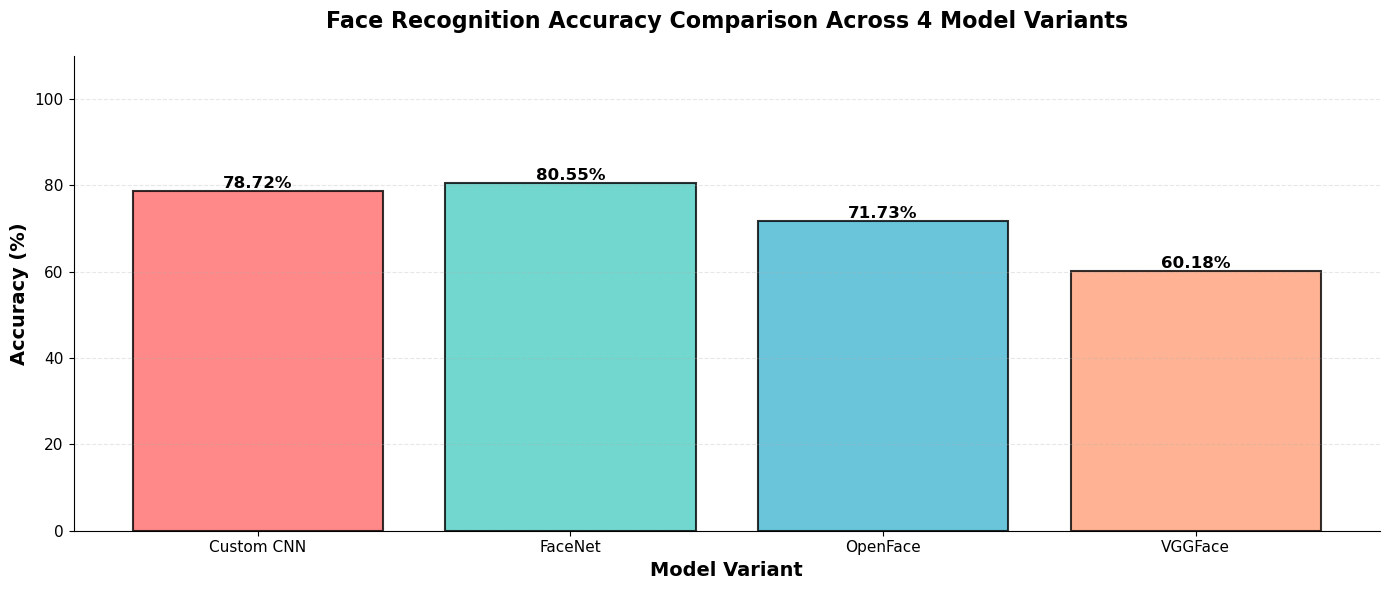


 ACCURACY SUMMARY:
----------------------------------------------------------------------------------------------------
  Variant 1: Custom CNN          :  78.72%
  Variant 2: FaceNet             :  80.55%
  Variant 3: OpenFace NN4        :  71.73%
  Variant 4: VGGFace             :  60.18%


In [27]:
# Accuracy Comparison - Bar Chart
print("="*100)
print(" "*35 + "ACCURACY COMPARISON")
print("="*100)

fig, ax = plt.subplots(figsize=(14, 6))

model_names = [result['short_name'] for result in all_results]
accuracies = [result['accuracy'] * 100 for result in all_results]

# Create bar chart with custom colors 
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = ax.bar(model_names, accuracies, color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
ax.set_ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Model Variant', fontsize=14, fontweight='bold')
ax.set_title('Face Recognition Accuracy Comparison Across 4 Model Variants', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylim(0, 110)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

# Print summary
print("\n ACCURACY SUMMARY:")
print("-" * 100)
for result in all_results:
    print(f"  {result['name']:<30} : {result['accuracy']*100:6.2f}%")
print("="*100)

                         PRECISION, RECALL, F1-SCORE COMPARISON


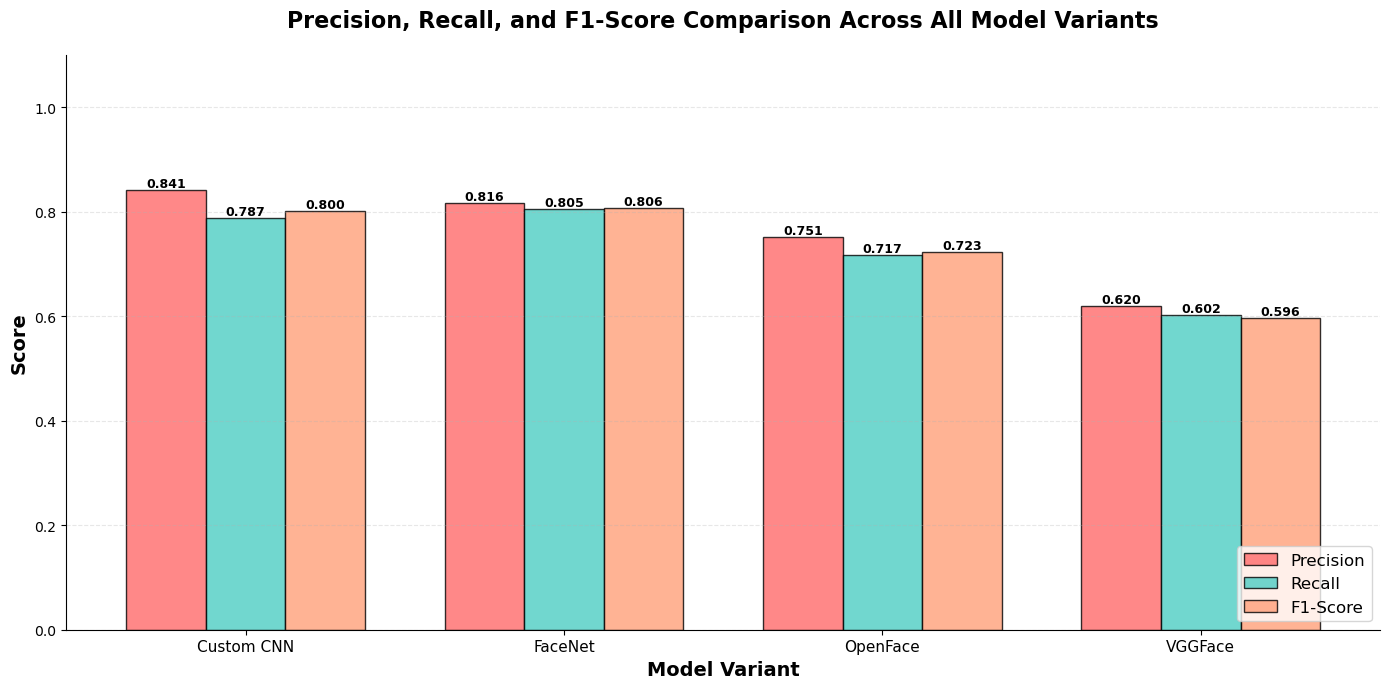


DETAILED METRICS:
----------------------------------------------------------------------------------------------------
Model                          | Precision    | Recall       | F1-Score    
----------------------------------------------------------------------------------------------------
Variant 1: Custom CNN          | 0.8405       | 0.7872       | 0.8003      
Variant 2: FaceNet             | 0.8161       | 0.8055       | 0.8065      
Variant 3: OpenFace NN4        | 0.7513       | 0.7173       | 0.7227      
Variant 4: VGGFace             | 0.6198       | 0.6018       | 0.5963      


In [28]:
# Precision, Recall, F1-Score Comparison
print("="*100)
print(" "*25 + "PRECISION, RECALL, F1-SCORE COMPARISON")
print("="*100)

fig, ax = plt.subplots(figsize=(14, 7))

model_names = [result['short_name'] for result in all_results]
precisions = [result['precision'] for result in all_results]
recalls = [result['recall'] for result in all_results]
f1_scores = [result['f1'] for result in all_results]

x = np.arange(len(model_names))
width = 0.25

# Create grouped bar chart
bars1 = ax.bar(x - width, precisions, width, label='Precision', 
               color='#FF6B6B', edgecolor='black', linewidth=1, alpha=0.8)
bars2 = ax.bar(x, recalls, width, label='Recall', 
               color='#4ECDC4', edgecolor='black', linewidth=1, alpha=0.8)
bars3 = ax.bar(x + width, f1_scores, width, label='F1-Score', 
               color='#FFA07A', edgecolor='black', linewidth=1, alpha=0.8)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Styling
ax.set_ylabel('Score', fontsize=14, fontweight='bold')
ax.set_xlabel('Model Variant', fontsize=14, fontweight='bold')
ax.set_title('Precision, Recall, and F1-Score Comparison Across All Model Variants', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(model_names, fontsize=11)
ax.set_ylim(0, 1.1)
ax.legend(fontsize=12, loc='lower right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDETAILED METRICS:")
print("-" * 100)
print(f"{'Model':<30} | {'Precision':<12} | {'Recall':<12} | {'F1-Score':<12}")
print("-" * 100)
for result in all_results:
    print(f"{result['name']:<30} | {result['precision']:<12.4f} | "
          f"{result['recall']:<12.4f} | {result['f1']:<12.4f}")
print("="*100)

                                   CONFUSION MATRICES

[1/4] Generating confusion matrix for Variant 1: Custom CNN...

[2/4] Generating confusion matrix for Variant 2: FaceNet...

[3/4] Generating confusion matrix for Variant 3: OpenFace NN4...

[4/4] Generating confusion matrix for Variant 4: VGGFace...


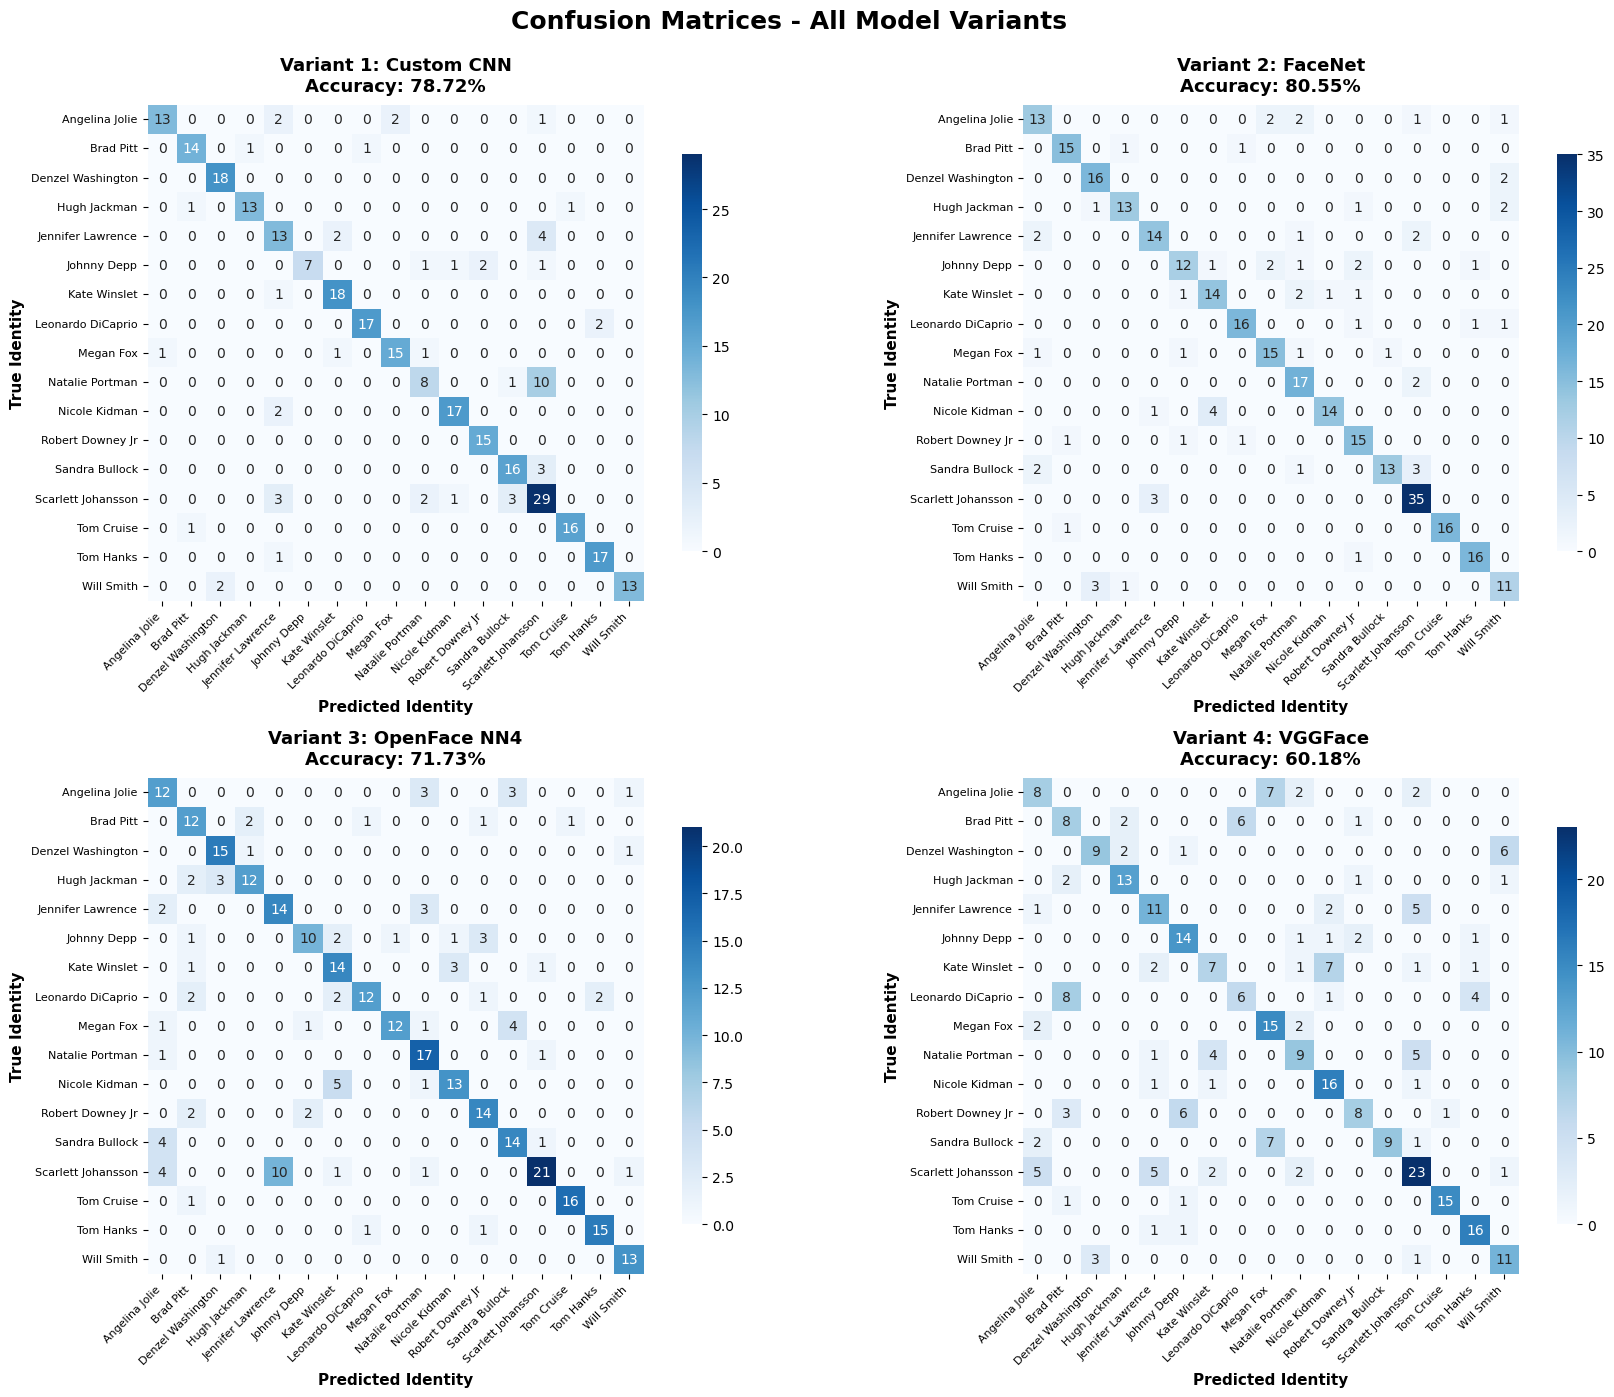


 Confusion matrices generated successfully!


In [29]:
# Confusion Matrices for All Models
print("="*100)
print(" "*35 + "CONFUSION MATRICES")
print("="*100)

# Create subplot for all confusion matrices (2x2 grid for 4 models)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

# Get sorted list of all unique identities
all_identities = sorted(list(set(test_labels)))

for idx, result in enumerate(all_results):
    print(f"\n[{idx+1}/4] Generating confusion matrix for {result['name']}...")
    
    # Calculate confusion matrix
    cm = confusion_matrix(result['ground_truth'], result['predictions'], 
                         labels=all_identities)
    
    # Plot confusion matrix
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=all_identities, yticklabels=all_identities,
                cbar=True, square=True, ax=ax, 
                cbar_kws={'shrink': 0.8})
    
    ax.set_title(f'{result["name"]}\nAccuracy: {result["accuracy"]*100:.2f}%', 
                 fontsize=13, fontweight='bold', pad=10)
    ax.set_ylabel('True Identity', fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted Identity', fontsize=11, fontweight='bold')
    
    # Rotate labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=8)

plt.suptitle('Confusion Matrices - All Model Variants', 
             fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n Confusion matrices generated successfully!")
print("="*100)

In [31]:
# Detailed Classification Report for Each Model
print("\n" + "="*100)
print(" "*30 + "DETAILED CLASSIFICATION REPORTS")
print("="*100)

for result in all_results:
    print(f"\n{'='*100}")
    print(f" {result['name'].center(98)} ")
    print(f"{'='*100}\n")
    
    # Generate classification report
    report = classification_report(result['ground_truth'], result['predictions'], 
                                   zero_division=0)
    print(report)
    print("="*100)

print("\n Classification reports generated successfully!")
print("="*100)


                              DETAILED CLASSIFICATION REPORTS

                                       Variant 1: Custom CNN                                        

                    precision    recall  f1-score   support

    Angelina Jolie       0.93      0.68      0.79        19
         Brad Pitt       0.88      0.82      0.85        17
 Denzel Washington       0.90      1.00      0.95        18
      Hugh Jackman       0.93      0.76      0.84        17
 Jennifer Lawrence       0.59      0.68      0.63        19
       Johnny Depp       1.00      0.37      0.54        19
      Kate Winslet       0.86      0.95      0.90        19
 Leonardo DiCaprio       0.94      0.89      0.92        19
         Megan Fox       0.88      0.79      0.83        19
   Natalie Portman       0.67      0.42      0.52        19
     Nicole Kidman       0.89      0.89      0.89        19
  Robert Downey Jr       0.88      0.83      0.86        18
    Sandra Bullock       0.80      0.84      0.82    

                          SAMPLE PREDICTIONS

 Visualizing predictions for 12 sample images...



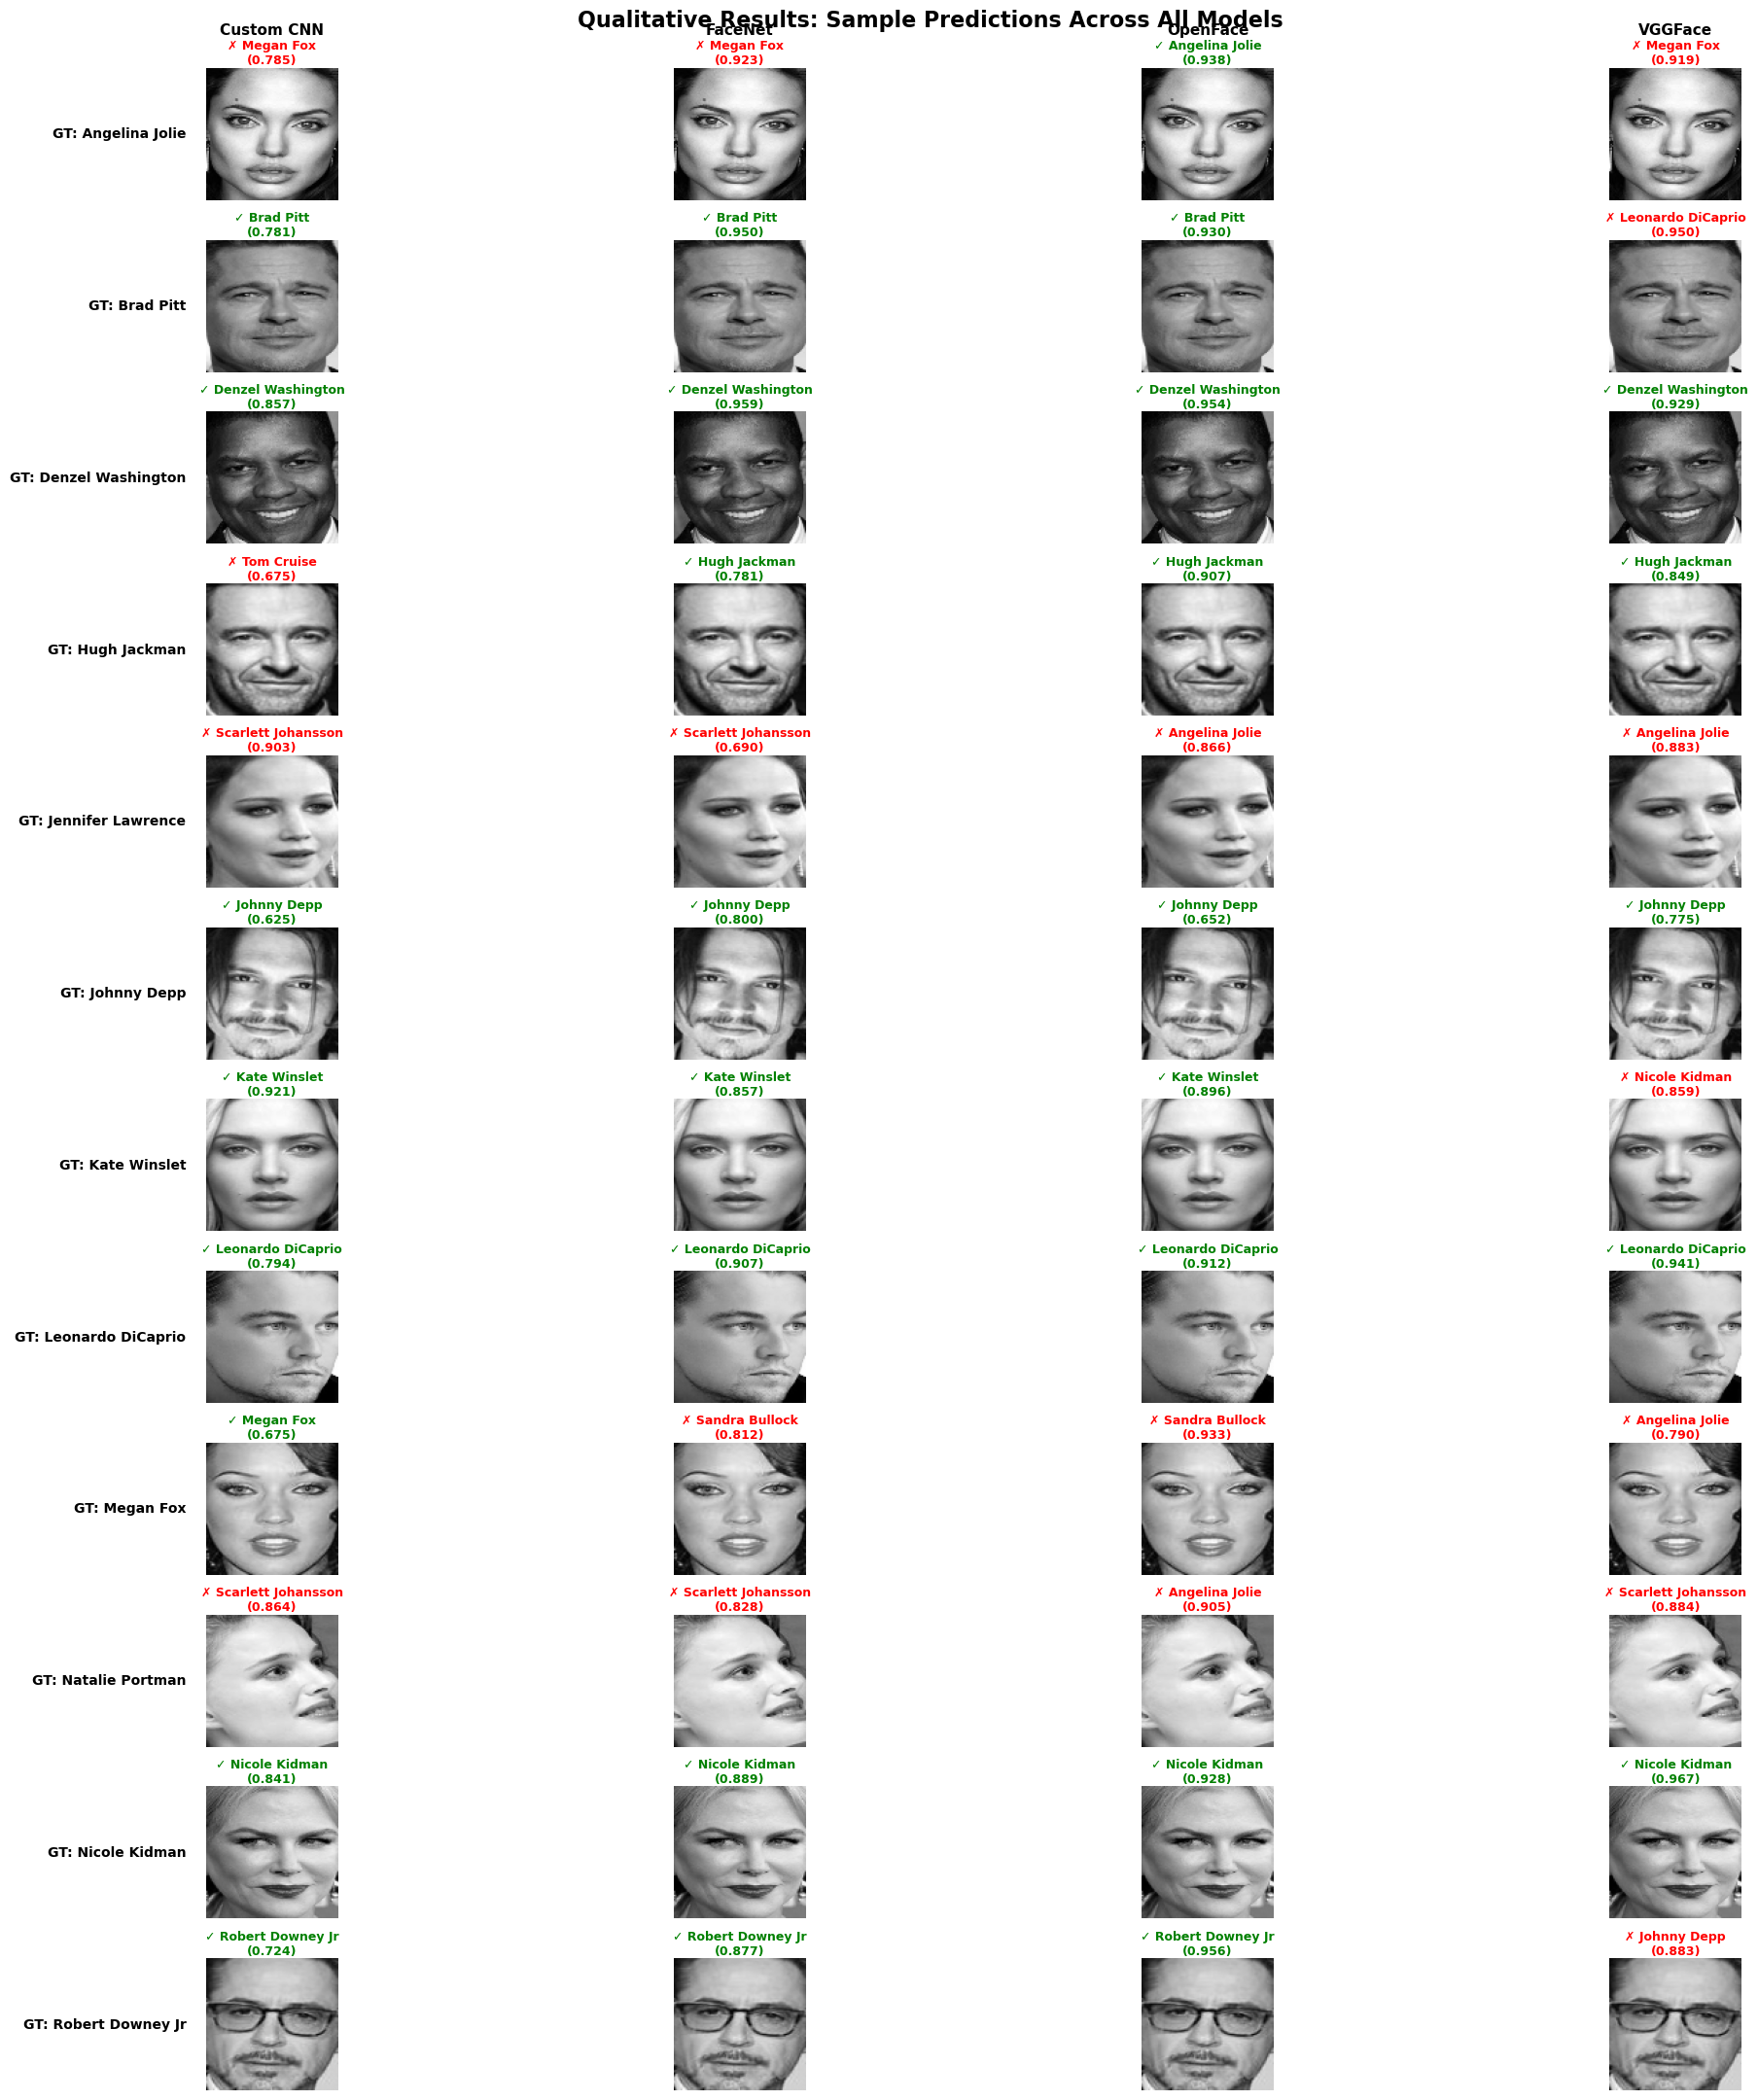

 Qualitative visualization complete!


In [33]:
# Qualitative Results - Sample Predictions Visualization
print("="*100)
print(" "*25 + " SAMPLE PREDICTIONS")
print("="*100)

# Select random samples from test set (one per identity if possible)
np.random.seed(42)
sample_indices = []

# Try to get one sample per identity
for identity in all_identities[:12]:  # Limit to 12 for visualization
    identity_indices = [i for i, label in enumerate(test_labels) if label == identity]
    if identity_indices:
        sample_indices.append(np.random.choice(identity_indices))

print(f"\n Visualizing predictions for {len(sample_indices)} sample images...\n")

# Create large figure for all models (4 columns now)
fig = plt.figure(figsize=(20, len(sample_indices) * 1.8))

# Plot predictions for each model
for model_idx, result in enumerate(all_results):
    for sample_idx, test_idx in enumerate(sample_indices):
        subplot_idx = sample_idx * 4 + model_idx + 1
        ax = plt.subplot(len(sample_indices), 4, subplot_idx)
        
        # Get image and predictions
        img = test_data[test_idx].squeeze()
        true_label = result['ground_truth'][test_idx]
        pred_label = result['predictions'][test_idx]
        similarity = result['similarities'][test_idx]
        
        # Display image
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        # Determine if prediction is correct
        is_correct = (true_label == pred_label)
        color = 'green' if is_correct else 'red'
        symbol = '✓' if is_correct else '✗'
        
        # Add title with prediction info
        title = f"{symbol} {pred_label}\n({similarity:.3f})"
        ax.set_title(title, fontsize=9, fontweight='bold', color=color, pad=3)
        
        # Add row label (ground truth) on the left
        if model_idx == 0:
            ax.text(-0.15, 0.5, f'GT: {true_label}', 
                   transform=ax.transAxes, fontsize=10, 
                   fontweight='bold', va='center', ha='right')
        
        # Add column label (model name) at the top
        if sample_idx == 0:
            ax.text(0.5, 1.25, result['short_name'], 
                   transform=ax.transAxes, fontsize=11, 
                   fontweight='bold', ha='center')

plt.suptitle('Qualitative Results: Sample Predictions Across All Models', 
             fontsize=16, fontweight='bold', y=0.998)
plt.tight_layout()
plt.subplots_adjust(top=0.97, hspace=0.3, wspace=0.1)
plt.show()

print(" Qualitative visualization complete!")
print("="*100)

                    DETAILED QUALITATIVE RESULTS - INDIVIDUAL MODELS

📷 Visualizing detailed predictions for 24 images...

[1/4] Generating visualization for Variant 1: Custom CNN...


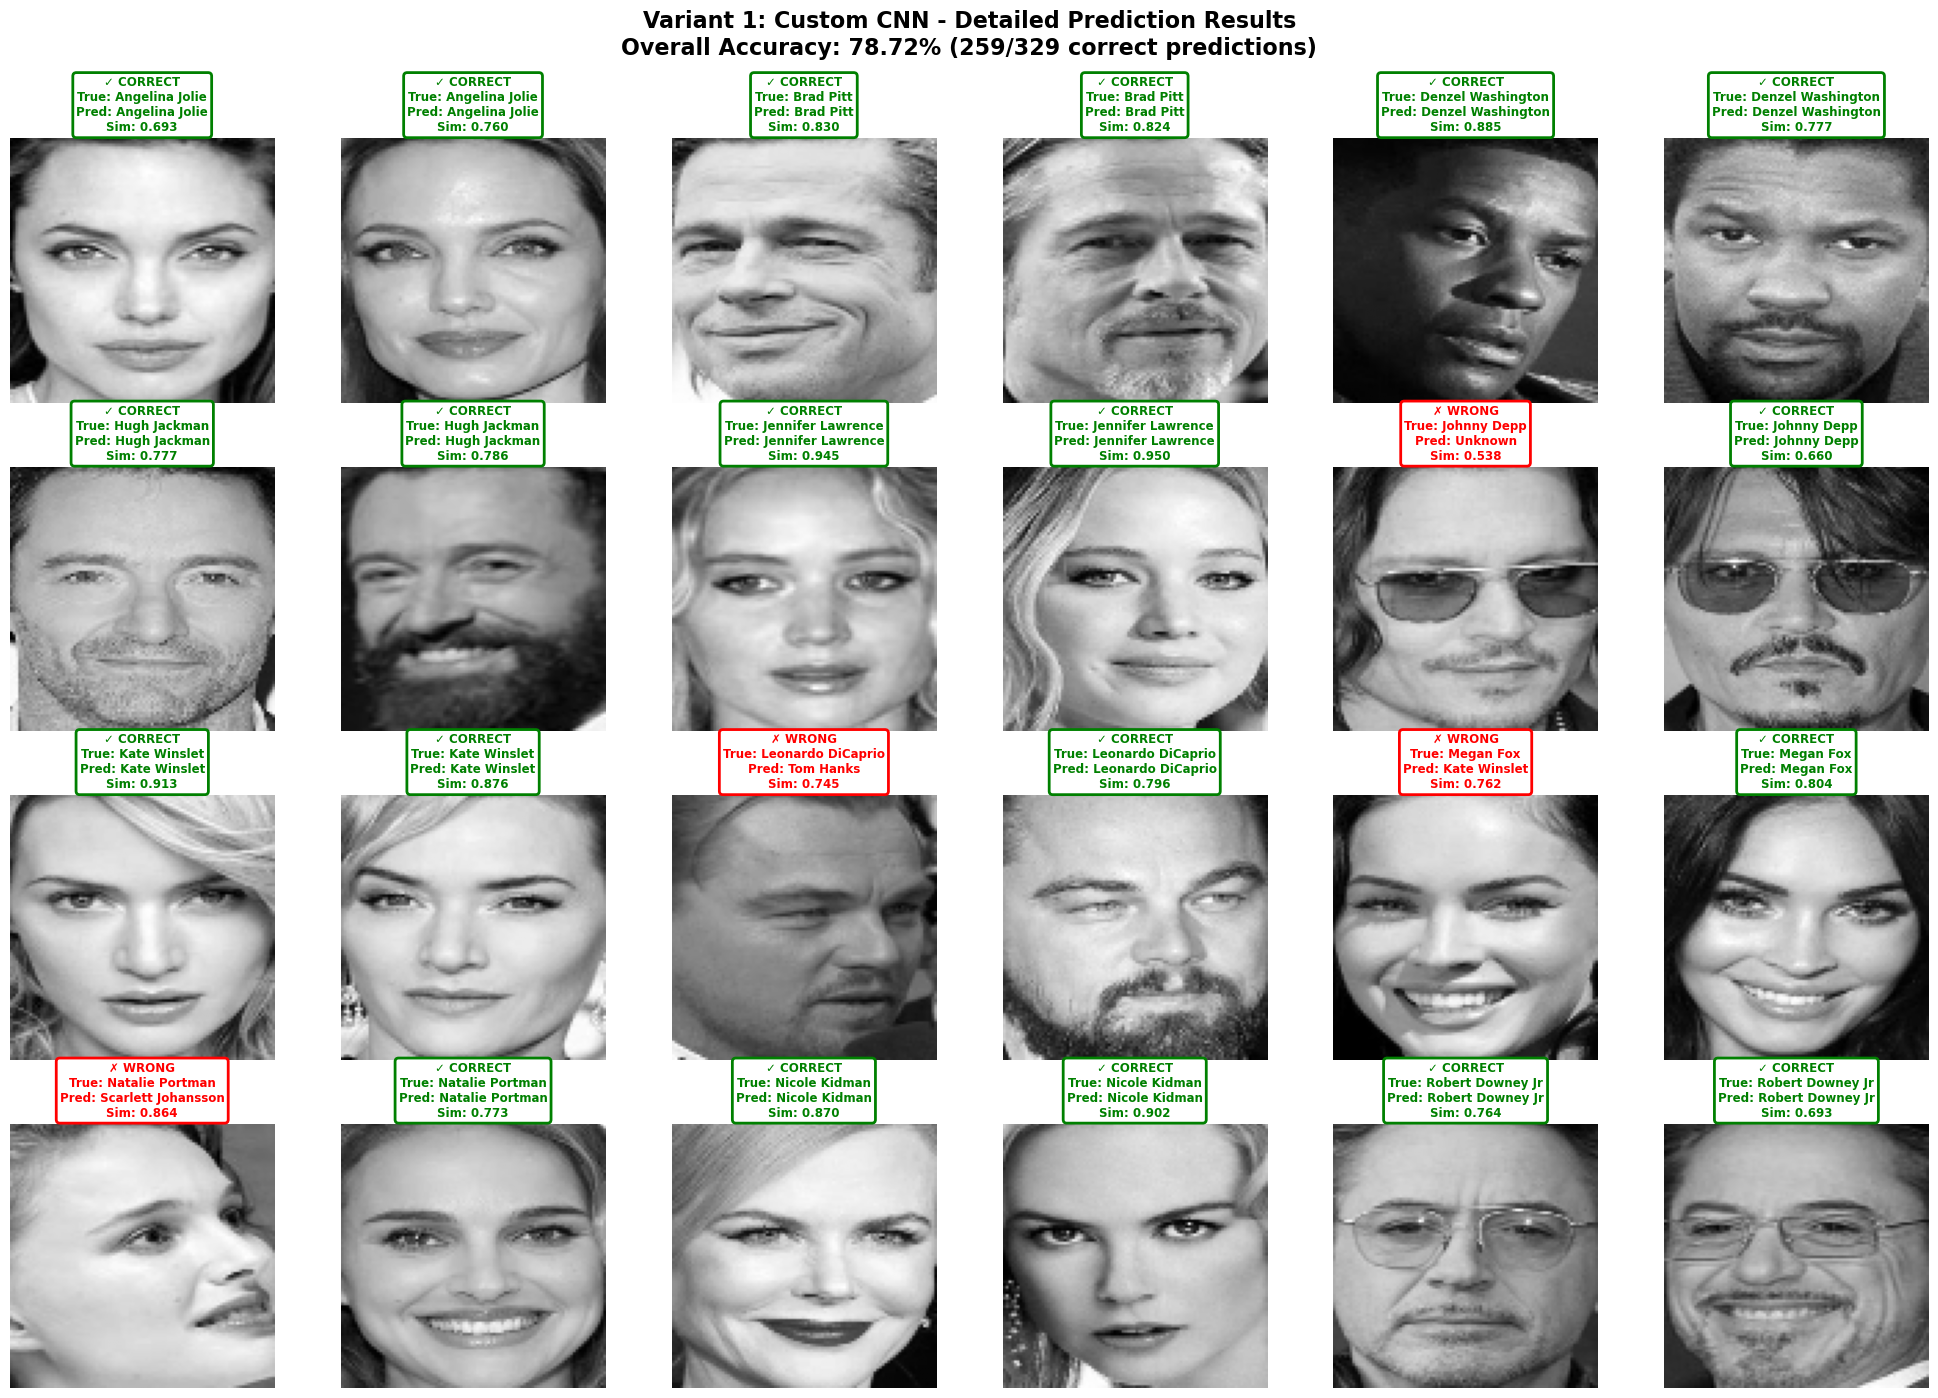

[2/4] Generating visualization for Variant 2: FaceNet...


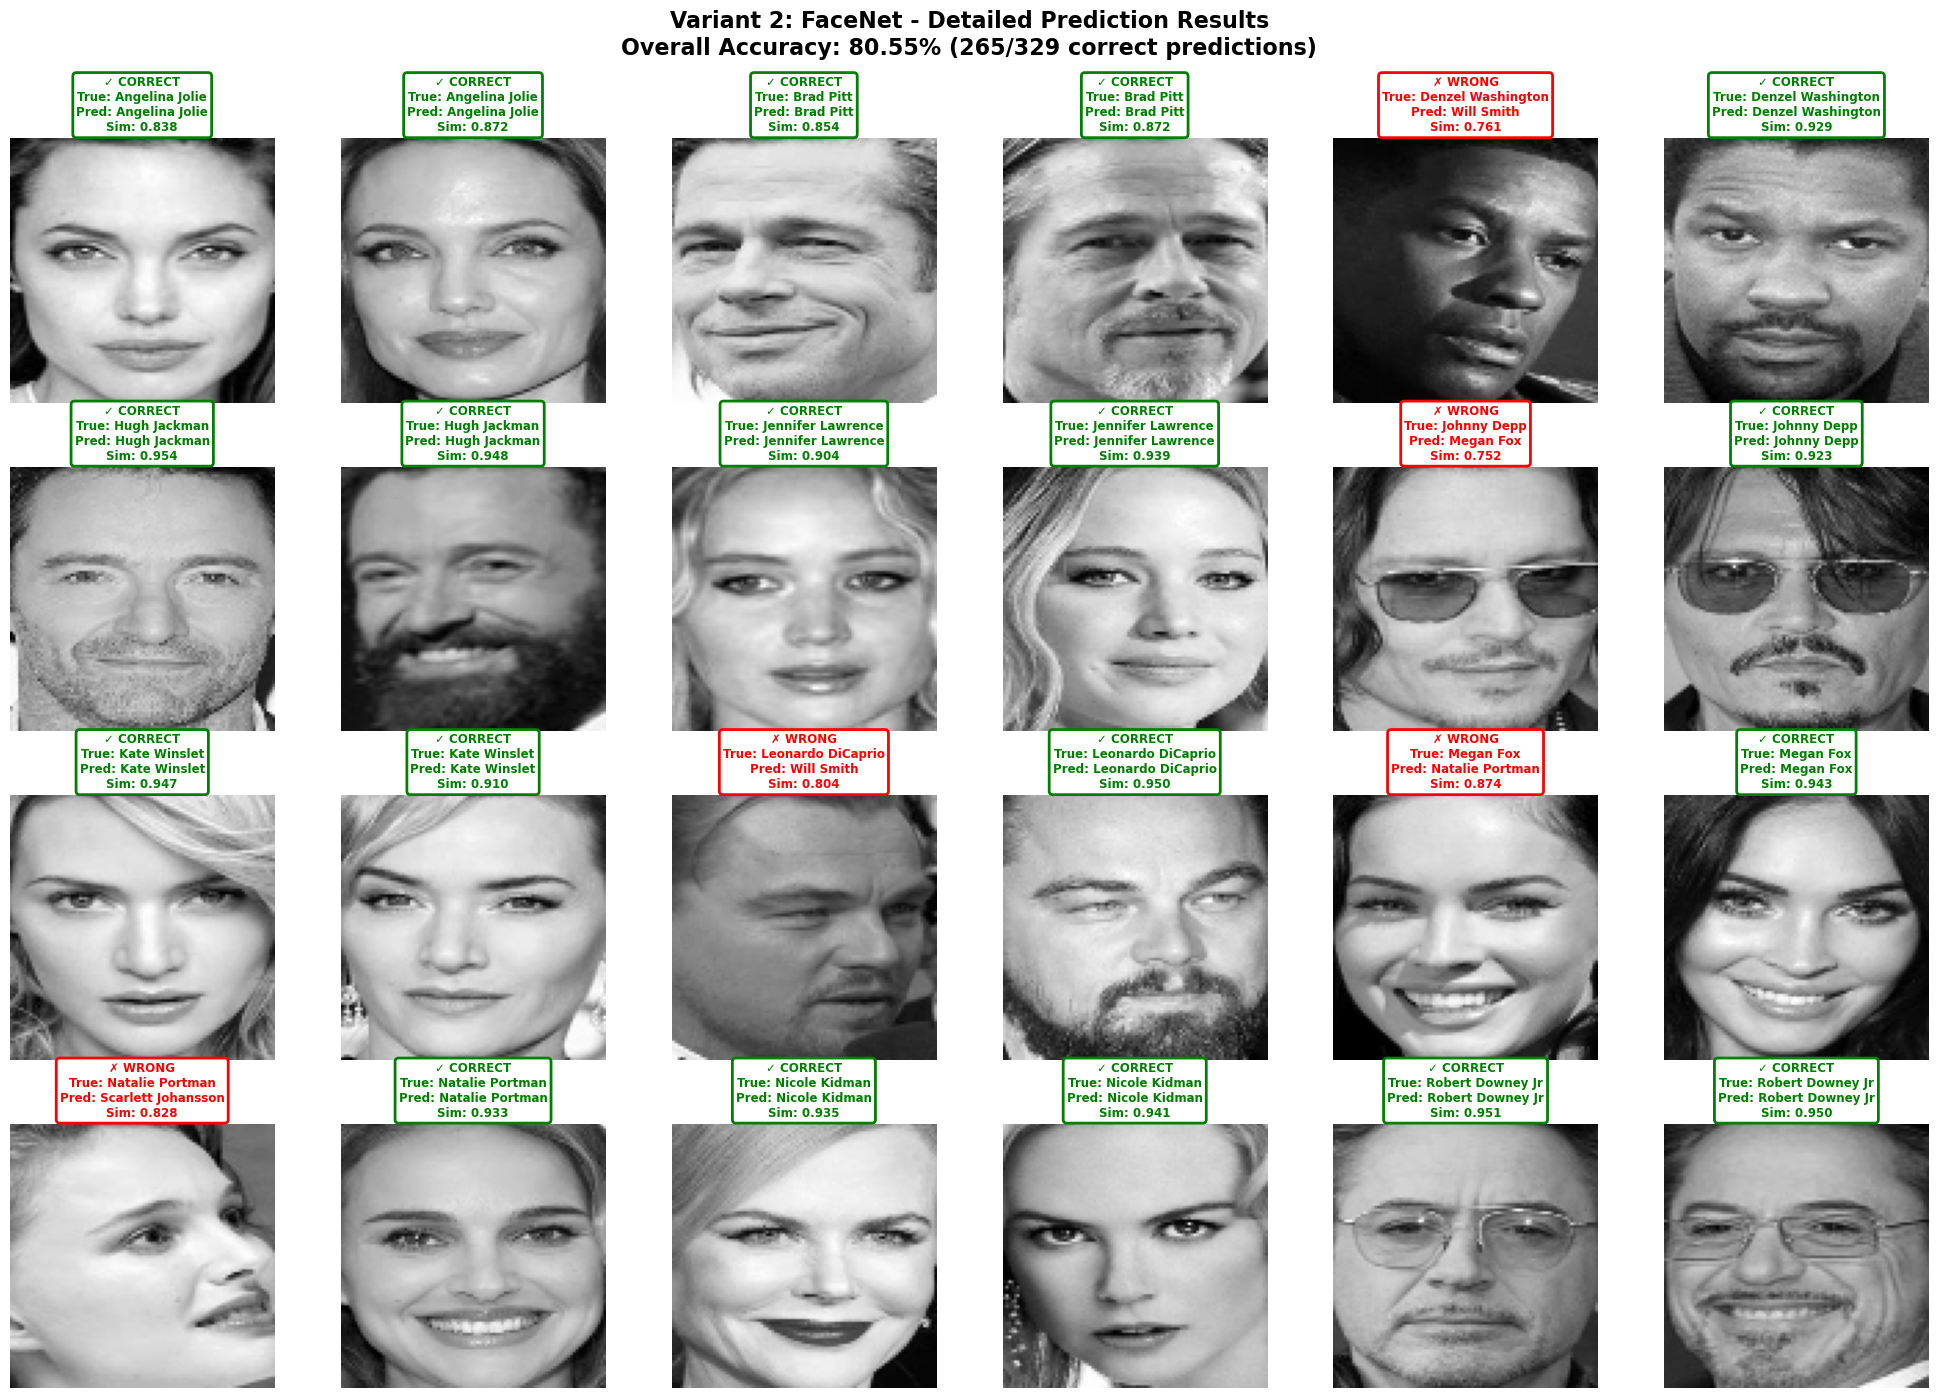

[3/4] Generating visualization for Variant 3: OpenFace NN4...


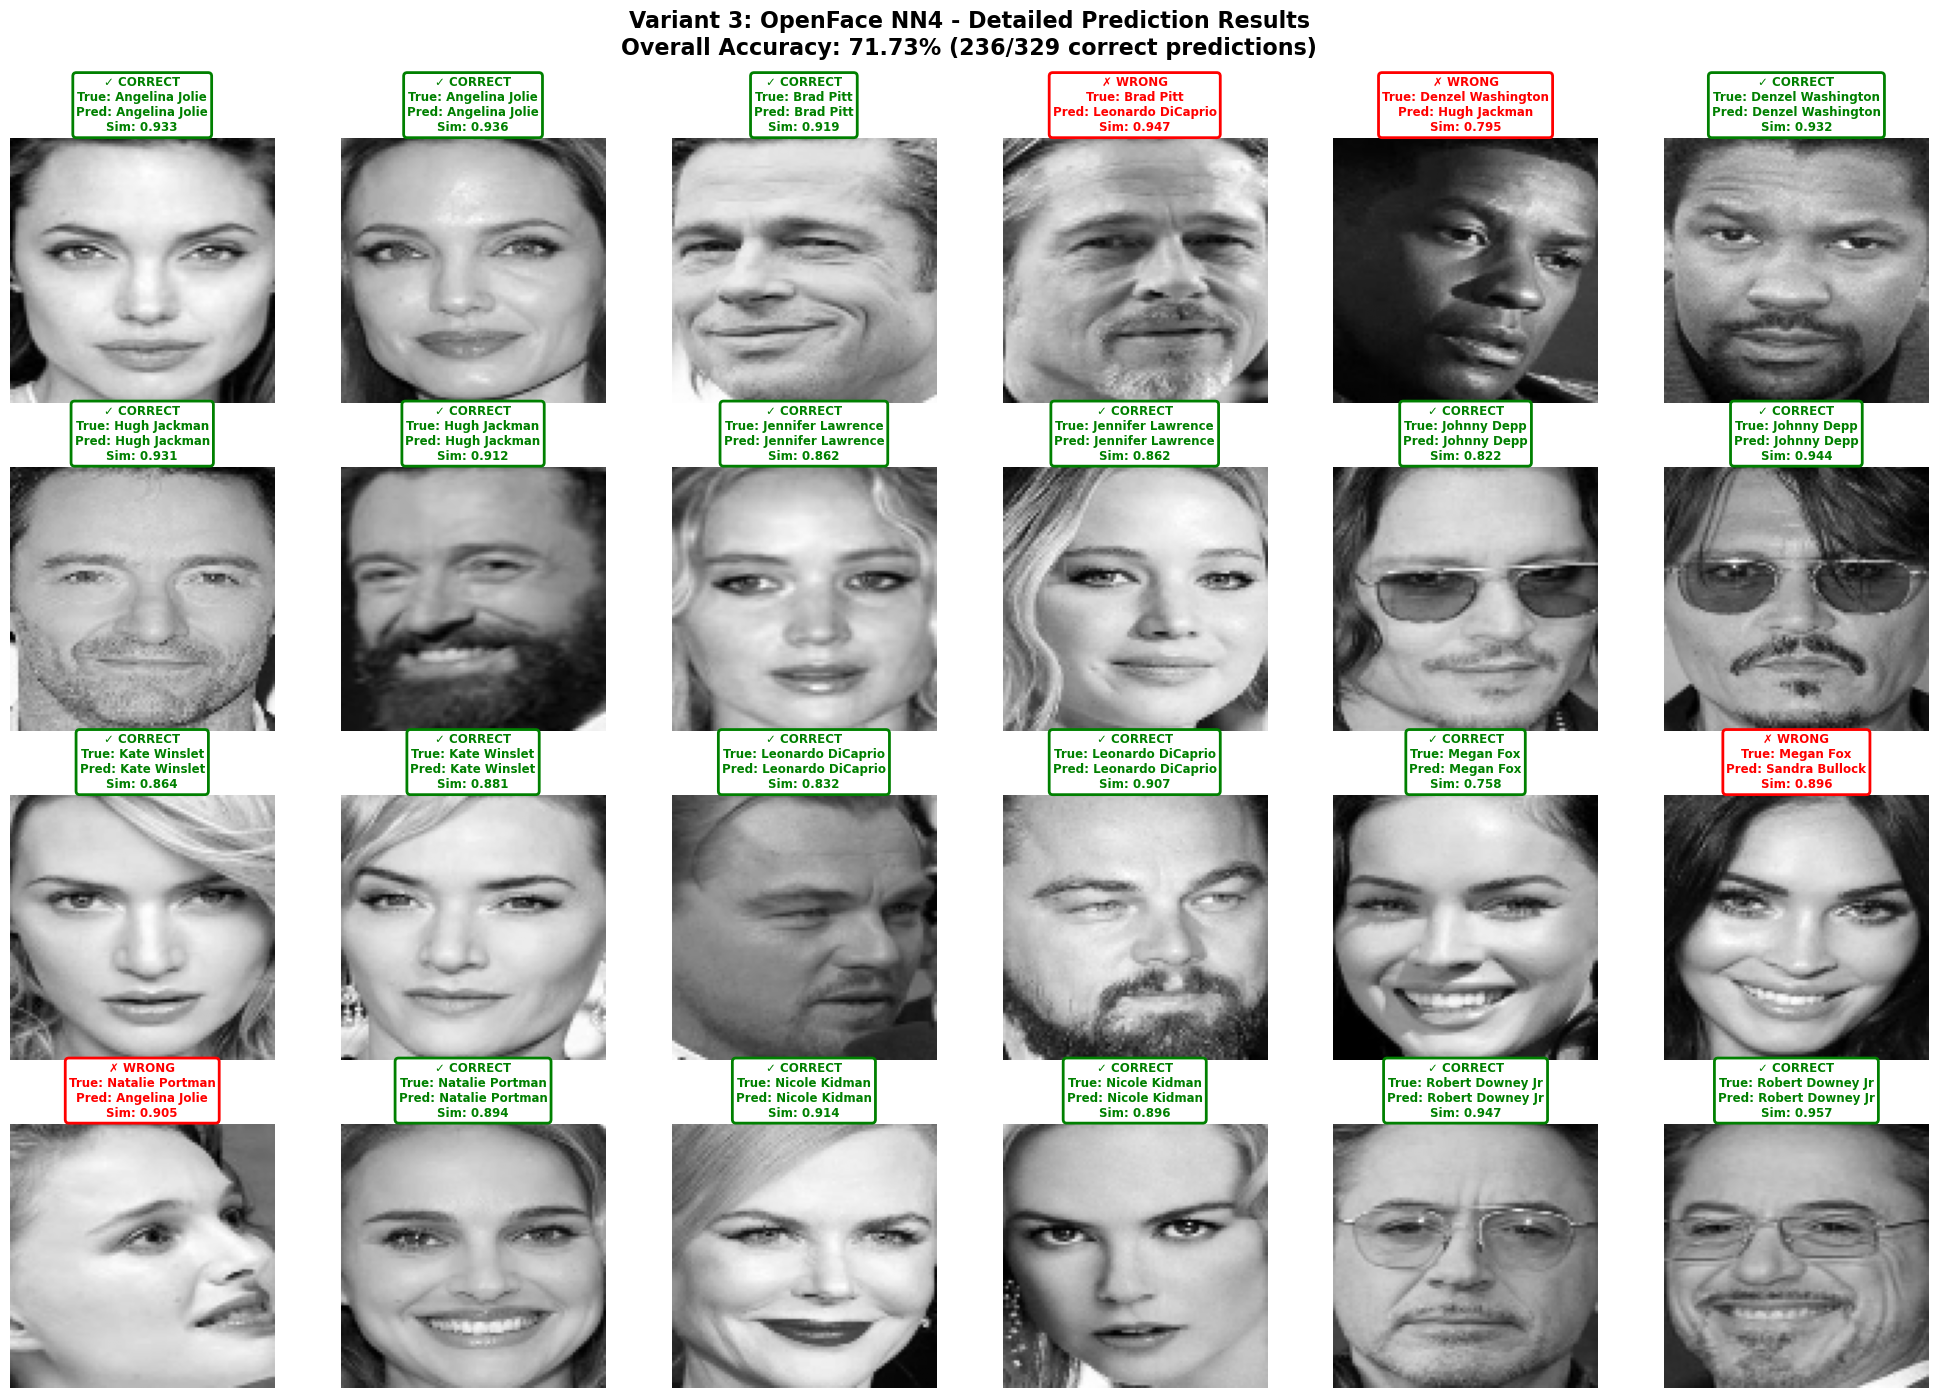

[4/4] Generating visualization for Variant 4: VGGFace...


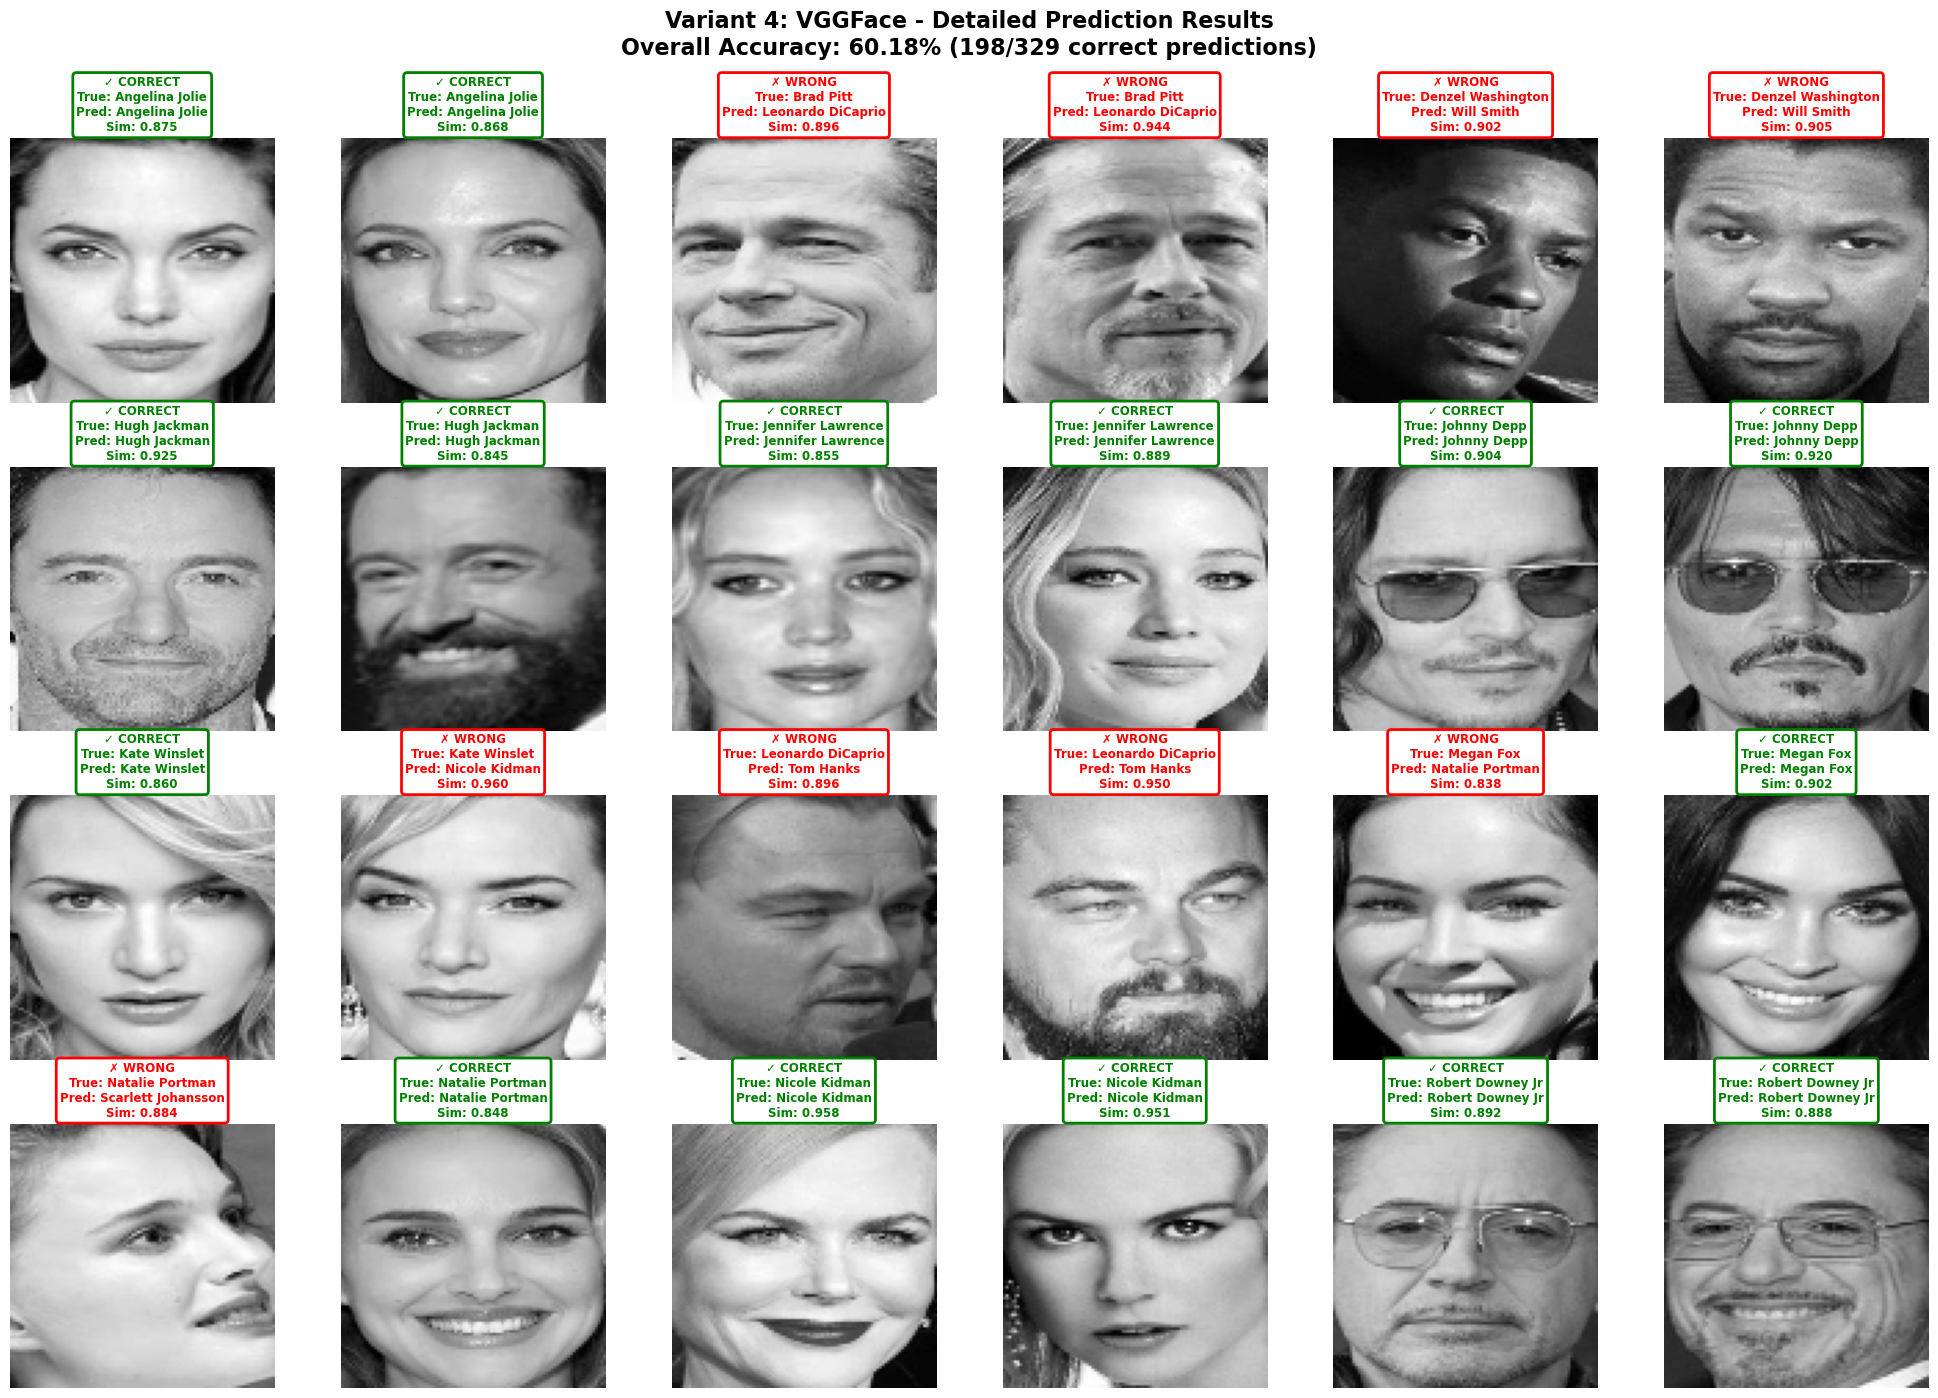


✓ All detailed visualizations generated!


In [34]:
# Detailed Qualitative Results - Individual Model Predictions
print("="*100)
print(" "*20 + "DETAILED QUALITATIVE RESULTS - INDIVIDUAL MODELS")
print("="*100)

# Select more diverse samples for detailed view
np.random.seed(123)
detailed_samples = []

# Get 2-3 samples per identity (up to 24 total images)
for identity in all_identities:
    identity_indices = [i for i, label in enumerate(test_labels) if label == identity]
    if identity_indices:
        num_samples = min(2, len(identity_indices))
        selected = np.random.choice(identity_indices, num_samples, replace=False)
        detailed_samples.extend(selected)

# Limit to 24 samples for better visualization
detailed_samples = detailed_samples[:24]

print(f"\n Visualizing detailed predictions for {len(detailed_samples)} images...\n")

# Create separate figure for each model with more details
for model_idx, result in enumerate(all_results):
    print(f"[{model_idx+1}/4] Generating visualization for {result['name']}...")
    
    fig, axes = plt.subplots(4, 6, figsize=(20, 14))
    axes = axes.flatten()
    
    for idx, test_idx in enumerate(detailed_samples):
        ax = axes[idx]
        
        # Get image and predictions
        img = test_data[test_idx].squeeze()
        true_label = result['ground_truth'][test_idx]
        pred_label = result['predictions'][test_idx]
        similarity = result['similarities'][test_idx]
        
        # Display image
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        
        # Determine if prediction is correct
        is_correct = (true_label == pred_label)
        
        # Create detailed title
        if is_correct:
            color = 'green'
            title = f"✓ CORRECT\nTrue: {true_label}\nPred: {pred_label}\nSim: {similarity:.3f}"
        else:
            color = 'red'
            title = f"✗ WRONG\nTrue: {true_label}\nPred: {pred_label}\nSim: {similarity:.3f}"
        
        ax.set_title(title, fontsize=8.5, fontweight='bold', color=color, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                             edgecolor=color, linewidth=2), pad=5)
    
    # Add model info as suptitle
    correct_count = sum([1 for gt, pred in zip(result['ground_truth'], result['predictions']) if gt == pred])
    total_count = len(result['ground_truth'])
    
    fig.suptitle(f"{result['name']} - Detailed Prediction Results\n"
                f"Overall Accuracy: {result['accuracy']*100:.2f}% ({correct_count}/{total_count} correct predictions)", 
                fontsize=16, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    plt.show()

print("\n✓ All detailed visualizations generated!")
print("="*100)

In [35]:
# Final Summary - Model Comparison Table
print("\n" + "="*100)
print(" "*30 + "FINAL EVALUATION SUMMARY")
print("="*100)

# Create comprehensive comparison table
print("\nCOMPREHENSIVE MODEL COMPARISON")
print("-" * 100)
print(f"{'Model':<30} | {'Accuracy':<10} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}")
print("-" * 100)

for result in all_results:
    print(f"{result['name']:<30} | {result['accuracy']*100:>8.2f}% | "
          f"{result['precision']:>9.4f} | {result['recall']:>9.4f} | {result['f1']:>9.4f}")

print("-" * 100)

# Find best performing model
best_model_idx = np.argmax([r['accuracy'] for r in all_results])
best_model = all_results[best_model_idx]

print(f"\nBEST PERFORMING MODEL: {best_model['name']}")
print(f"   Accuracy: {best_model['accuracy']*100:.2f}%")
print(f"   Precision: {best_model['precision']:.4f}")
print(f"   Recall: {best_model['recall']:.4f}")
print(f"   F1-Score: {best_model['f1']:.4f}")

# Additional statistics
print(f"\n📈 STATISTICS:")
print(f"   Total test images: {len(test_data)}")
print(f"   Number of identities: {len(all_identities)}")
print(f"   Average accuracy across all models: {np.mean([r['accuracy'] for r in all_results])*100:.2f}%")
print(f"   Accuracy std deviation: {np.std([r['accuracy'] for r in all_results])*100:.2f}%")
print(f"   Best-worst accuracy gap: {(max([r['accuracy'] for r in all_results]) - min([r['accuracy'] for r in all_results]))*100:.2f}%")

print("\n" + "="*100)
print(" "*25 + " COMPREHENSIVE EVALUATION COMPLETE!")
print("="*100)


                              FINAL EVALUATION SUMMARY

COMPREHENSIVE MODEL COMPARISON
----------------------------------------------------------------------------------------------------
Model                          | Accuracy   | Precision  | Recall     | F1-Score  
----------------------------------------------------------------------------------------------------
Variant 1: Custom CNN          |    78.72% |    0.8405 |    0.7872 |    0.8003
Variant 2: FaceNet             |    80.55% |    0.8161 |    0.8055 |    0.8065
Variant 3: OpenFace NN4        |    71.73% |    0.7513 |    0.7173 |    0.7227
Variant 4: VGGFace             |    60.18% |    0.6198 |    0.6018 |    0.5963
----------------------------------------------------------------------------------------------------

BEST PERFORMING MODEL: Variant 2: FaceNet
   Accuracy: 80.55%
   Precision: 0.8161
   Recall: 0.8055
   F1-Score: 0.8065

📈 STATISTICS:
   Total test images: 329
   Number of identities: 17
   Average accuracy